In [2]:
import pickle
import os
import re
import json
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.stats import kstest, shapiro, normaltest, zscore
import statsmodels.api as sm
import matplotlib.patches as mpatches
import pingouin as pg

from functools import reduce

In [3]:
# Enable automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2


import plotting as pl
from models import model as md
import utils as ut

In [4]:
def max_epoch(l_files):
    the_number = []
    for f in l_files:
        # extract number and store
        mtch = re.search(r"epoch(\d{4})\.txt$", f)
        try:
            the_number.append(mtch.groups()[0])
        except:
            the_number.append("0")
    the_number_int = [int(n) for n in the_number]
    max_value = max(the_number_int)
    indices = [index for index, value in enumerate(the_number_int) if value == max_value]
    file_to_extract = l_files[indices[0]]
    file_to_extract = file_to_extract.replace(".txt", ".tar")
    file_to_extract = file_to_extract.replace("sparse_embed", "model")
    return file_to_extract

In [5]:
def extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype = "weightsonly_only_weights", l_temperature = []
):
    all_dirs = []
    l_all_results = []
    l_all_models = []
    l_sparsity = []
    l_subject = []
    for n in l_n:
        for splithalf in l_splithalf:
            for la in lmbda:
                for la_h in lmbda_hierarchical:
                    for sp in l_sparse:
                        for st in l_subjecttype:
                            if l_temperature == []:
                                results_dir_ID = os.path.join(
                                    "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}",
                                    f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                    )
                                all_dirs.append(results_dir_ID)
                                l_sparsity.append(sp)
                                l_subject.append(st)
                            else:
                                for temp in l_temperature:
                                    results_dir_ID = os.path.join(
                                        "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}", f"temperature_{temp}",
                                        f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                        )
                                    all_dirs.append(results_dir_ID)
                                    l_sparsity.append(sp)
                                    l_subject.append(st)
    for i, d in enumerate(all_dirs):
        file_path = os.path.join(d, 'results.json')
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                l_results = json.load(f)
                l_all_results.append(l_results)
        else:
            print(file_path + ": not found")
        l_files = os.listdir(results_dir_ID)
        latest_epoch = max_epoch(l_files)
        p = os.path.join(d, "model", latest_epoch)
        if os.path.isfile(p):
            m = torch.load(p, weights_only=True, map_location=torch.device("cpu"))
            m["sparsity"] = l_sparsity[i]
            m["subject_type"] = l_subject[i]
            l_all_models.append(m)
        else:
            print(f'{p} does not exist')
    return l_all_models

In [54]:
# by-participant decision models
lmbda = [0.0005]
lmbda_hierarchical = [0.01]
rnd_seed = '998877'
modelversion = "avg-ID-jointly-embeddings-decision"
l_n = [5, 10, 15, 20, 30, 40, 50]
l_sparse = ["items_and_random_ids"]#["ID", "both"] #"both", 
l_subjecttype = ["subjects_actual", "subjects_shuffled"]
l_splithalf = ["no"]
l_all_models_id_1 = extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse, 
    l_subjecttype, l_splithalf, modeltype="random_weights_free_scaling",
)

In [55]:
# by-participant embedding models (no by-participant decision models)
modelversion = "avg-ID-jointly-embeddings"
l_n = [20, 30, 40, 50]
l_temperature = [50.0, 10.0, 1.0, 0.009999999776482582]
l_subjecttype = ["subjects_actual", "subjects_shuffled"]
l_all_models_id_2 = extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights",
    l_temperature=l_temperature
)

In [56]:
# by-participant embedding models (no by-participant decision models)
lmbda_hierarchical = [0.0]
modelversion = "avg-ID-jointly-embeddings"
l_sparse = ["both"]
l_all_models_id_3 = extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="free_weights",
    l_temperature=l_temperature
)

In [57]:
l_models_decision = l_all_models_id_1
l_models_embedding_only = l_all_models_id_2 + l_all_models_id_3

In [10]:
def model_detail_dict(ls, embedding_only):
    l_df = [
        pd.DataFrame({
            "modeltype": l["modeltype"],
            "sparsity": l["sparsity"],
            "subject_type": l["subject_type"],
            "nr_epochs": l["epoch"],
            "ndim": l["n_embed"],
            "lambda": l["lambda"],
            "lambda_hierarchical": l["lmbda_hierarchical"],
            "train_acc_max": l["train_accs_max"],
            "val_acc_max": l["val_accs_max"],
            "train_acc_proba": l["train_accs_proba"],
            "val_acc_proba": l["val_accs_proba"],
        })
        for l in ls
    ]
    if embedding_only:
        for i, l in enumerate(l_df):
            l["temperature"] = ls[i]["temperature"].detach().numpy()
    return l_df

In [11]:
l_df_train_eval_id_embedding = model_detail_dict(l_models_embedding_only, True)
l_df_train_eval_id_decision = model_detail_dict(l_models_decision, False)

In [12]:
df_train_eval_id_decision = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), l_df_train_eval_id_decision)
df_train_eval_id_decision["epoch"] = df_train_eval_id_decision.groupby(
    ["modeltype", "sparsity", "subject_type", "ndim", "lambda", "lambda_hierarchical"]
).cumcount()
df_train_eval_id_embedding = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), l_df_train_eval_id_embedding)
df_train_eval_id_embedding["epoch"] = df_train_eval_id_embedding.groupby(
    ["modeltype", "sparsity", "subject_type", "temperature", "ndim", "lambda", "lambda_hierarchical"]
).cumcount()

In [13]:
df_train_eval_long_id_decision = pd.melt(
    df_train_eval_id_decision, 
    id_vars=["modeltype", "sparsity", "subject_type", "ndim", "lambda", "lambda_hierarchical", "epoch"], 
    value_vars = ["train_acc_max", "val_acc_max", "train_acc_proba", "val_acc_proba"], 
    var_name = "Variable",
    value_name = "Accuracy"
)

In [14]:
df_train_eval_long_id_embedding = pd.melt(
    df_train_eval_id_embedding, 
    id_vars=["modeltype", "sparsity", "temperature", "subject_type", "ndim", "lambda", "lambda_hierarchical", "epoch"], 
    value_vars = ["train_acc_max", "val_acc_max", "train_acc_proba", "val_acc_proba"], 
    var_name = "Variable",
    value_name = "Accuracy"
)

In [15]:
df_train_eval_long_id_embedding["temperature_rounded"] = df_train_eval_long_id_embedding["temperature"].round(2).astype(str)

In [16]:
df_train_eval_long_id_decision['lambda_ndim'] = df_train_eval_long_id_decision['lambda'].astype(str) + '_' + df_train_eval_long_id_decision['ndim'].astype(str)
df_train_eval_long_id_decision['modeltype_lh'] = df_train_eval_long_id_decision['modeltype'].astype(str) + '_' + df_train_eval_long_id_decision['lambda_hierarchical'].astype(str)

In [17]:
df_train_eval_long_id_embedding['lambda_ndim'] = df_train_eval_long_id_embedding['lambda'].astype(str) + '_' + df_train_eval_long_id_embedding['ndim'].astype(str)
df_train_eval_long_id_embedding['modeltype_lh'] = df_train_eval_long_id_embedding['modeltype'].astype(str) + '_' + df_train_eval_long_id_embedding['lambda_hierarchical'].astype(str)

In [18]:
df_train_eval_long_id_decision.rename(columns = {"modeltype":"md", "lambda":"l", "lambda_hierarchical":"lh"}, inplace=True)
df_train_eval_long_id_embedding.rename(columns = {"modeltype":"md", "lambda":"l", "lambda_hierarchical":"lh"}, inplace=True)

## only embedding models

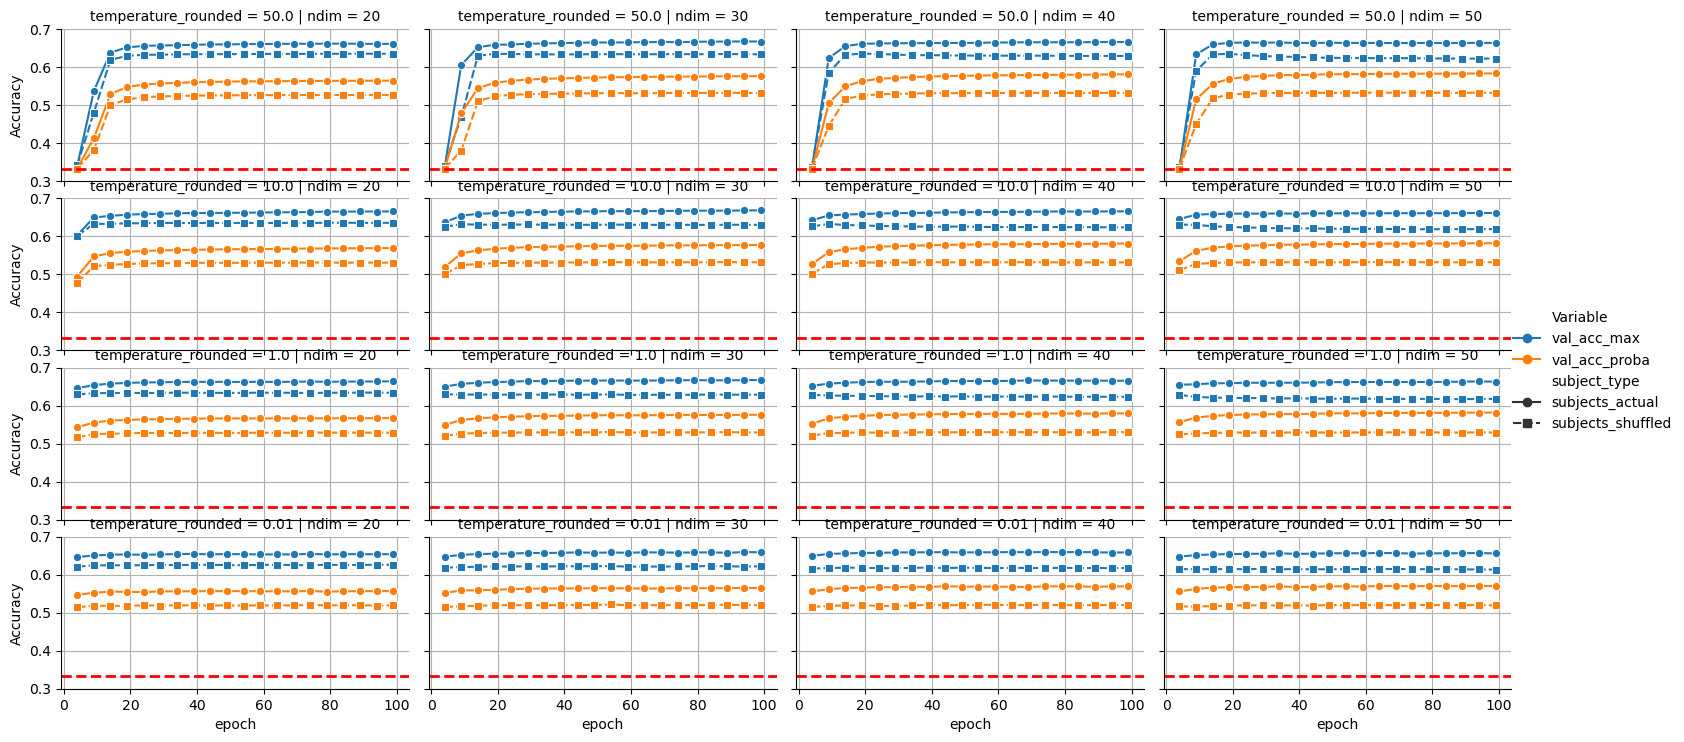

In [884]:
substring2 = "val_acc"
marker_styles = {
    "subjects_actual": "o",  # circle
    "subjects_shuffled": "s",  # square
}
# Create the FacetGrid without specifying an external axis
g = sns.relplot(
    data=df_train_eval_long_id_embedding.query(
        "(epoch + 1) % 5 == 0 & md == 'random_weights' & Variable.str.contains(@substring2)",
        engine="python"
    ), x='epoch', y='Accuracy', style = "subject_type", row="temperature_rounded", col="ndim", height=4,
    hue="Variable", marker="o", aspect=1, kind="line", markers=marker_styles
)
# Add gridlines to each facet z
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')

    ax.set_ylim(.3, .7)

plt.subplots_adjust(right=0.9)  # Increase from 0.8 to tuck it in

# Adjust the plot size
g.fig.set_size_inches(17,7)
g.fig.set_dpi(100)

plt.show()

In [883]:
substring2 = "val_acc"
df_embedding_best = df_train_eval_long_id_embedding.query(
    "Variable.str.contains(@substring2)", engine="python"
).groupby(
    ["md", "temperature", "subject_type", "ndim", "Variable"]
)["Accuracy"].max().reset_index()
df_embedding_best = df_embedding_best.pivot(
    index=["md", "temperature", "subject_type", "ndim"], 
    columns=["Variable"], values="Accuracy"
).reset_index()
df_embedding_best_modeltype = df_embedding_best.pivot(
    index=["temperature", "subject_type", "ndim"], 
    columns="md", values=["val_acc_max", "val_acc_proba"]
).reset_index()
# Assume df_pivot has MultiIndex columns after pivot
df_embedding_best_modeltype.columns = [
    '_'.join(col).rstrip('_') if isinstance(col, tuple) else str(col).rstrip('_') for col in df_embedding_best_modeltype.columns
]

df_embedding_best_modeltype.sort_values("val_acc_max_random_weights", ascending=False).head()

,temperature,subject_type,ndim,val_acc_max_free_weights,val_acc_max_random_weights,val_acc_proba_free_weights,val_acc_proba_random_weights
17,10.0,subjects_actual,30,0.669885,0.668422,0.577552,0.577686
25,50.0,subjects_actual,30,0.453014,0.668073,0.333337,0.576784
9,1.0,subjects_actual,30,0.670209,0.667424,0.577367,0.576144
26,50.0,subjects_actual,40,0.451774,0.666801,0.333338,0.581456
18,10.0,subjects_actual,40,0.667714,0.666160,0.580772,0.581325


### look at by-participant dimensional weights

### Compare random vs. free dimensional weights

In [58]:
for i, l in enumerate(l_models_embedding_only):
    print("i = ", i)
    print("subject_type = ", l["subject_type"])
    print("modeltype = ", l["modeltype"])
    print("ndim = ", l["n_embed"])
    print("lmbda hierarchical = ", l["lmbda_hierarchical"])
    print("temperature = ", l["temperature"], "\n")

i =  0
subject_type =  subjects_actual
modeltype =  random_weights
ndim =  20
lmbda hierarchical =  0.01
temperature =  tensor(50.) 

i =  1
subject_type =  subjects_actual
modeltype =  random_weights
ndim =  20
lmbda hierarchical =  0.01
temperature =  tensor(10.) 

i =  2
subject_type =  subjects_actual
modeltype =  random_weights
ndim =  20
lmbda hierarchical =  0.01
temperature =  tensor(1.) 

i =  3
subject_type =  subjects_actual
modeltype =  random_weights
ndim =  20
lmbda hierarchical =  0.01
temperature =  tensor(0.0100) 

i =  4
subject_type =  subjects_shuffled
modeltype =  random_weights
ndim =  20
lmbda hierarchical =  0.01
temperature =  tensor(50.) 

i =  5
subject_type =  subjects_shuffled
modeltype =  random_weights
ndim =  20
lmbda hierarchical =  0.01
temperature =  tensor(10.) 

i =  6
subject_type =  subjects_shuffled
modeltype =  random_weights
ndim =  20
lmbda hierarchical =  0.01
temperature =  tensor(1.) 

i =  7
subject_type =  subjects_shuffled
modeltype =  r

In [46]:
# cannot compare on temp = 50, even though random dim weights perform best, because free weights model performs at chance
df_dim_weights_random = pd.DataFrame(
    l_models_embedding_only[1]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
df_dim_weights_free = pd.DataFrame(
    l_models_embedding_only[33]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
df_dim_weights_random["id"] = df_dim_weights_random.index
df_dim_weights_random_long = df_dim_weights_random.melt(id_vars="id", var_name="Dimension")
df_dim_weights_random_long["modeltype"] = "random"
df_dim_weights_free["id"] = df_dim_weights_free.index
df_dim_weights_free_long = df_dim_weights_free.melt(id_vars="id", var_name="Dimension")
df_dim_weights_free_long["modeltype"] = "free"

df_dim_weights_long_both = pd.concat([df_dim_weights_free_long, df_dim_weights_random_long], axis=0)

In [47]:
# Define a function that returns two values
def summary(group):
    k2, pval = normaltest(group["value"])
    return pd.Series({
        'k2': k2,
        'pval': pval
    })

df_result = df_dim_weights_long_both.groupby(["Dimension", "modeltype"]).apply(summary).reset_index()
df_result_long = pd.melt(df_result, id_vars=["Dimension", "modeltype"])

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_17776\1412867902.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result = df_dim_weights_long_both.groupby(["Dimension", "modeltype"]).apply(summary).reset_index()


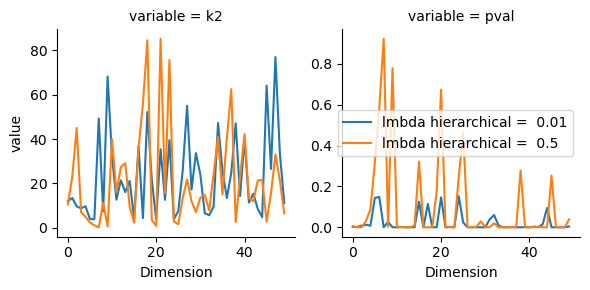

In [48]:
g = sns.FacetGrid(df_result_long, col="variable", sharey=False)
g.map_dataframe(sns.lineplot, x = "Dimension", y = "value", hue="modeltype")
_ = plt.legend()

In [49]:
df_dim_weights_long_both["value_z"] = df_dim_weights_long_both.groupby(["Dimension", "modeltype"])["value"].transform(zscore)

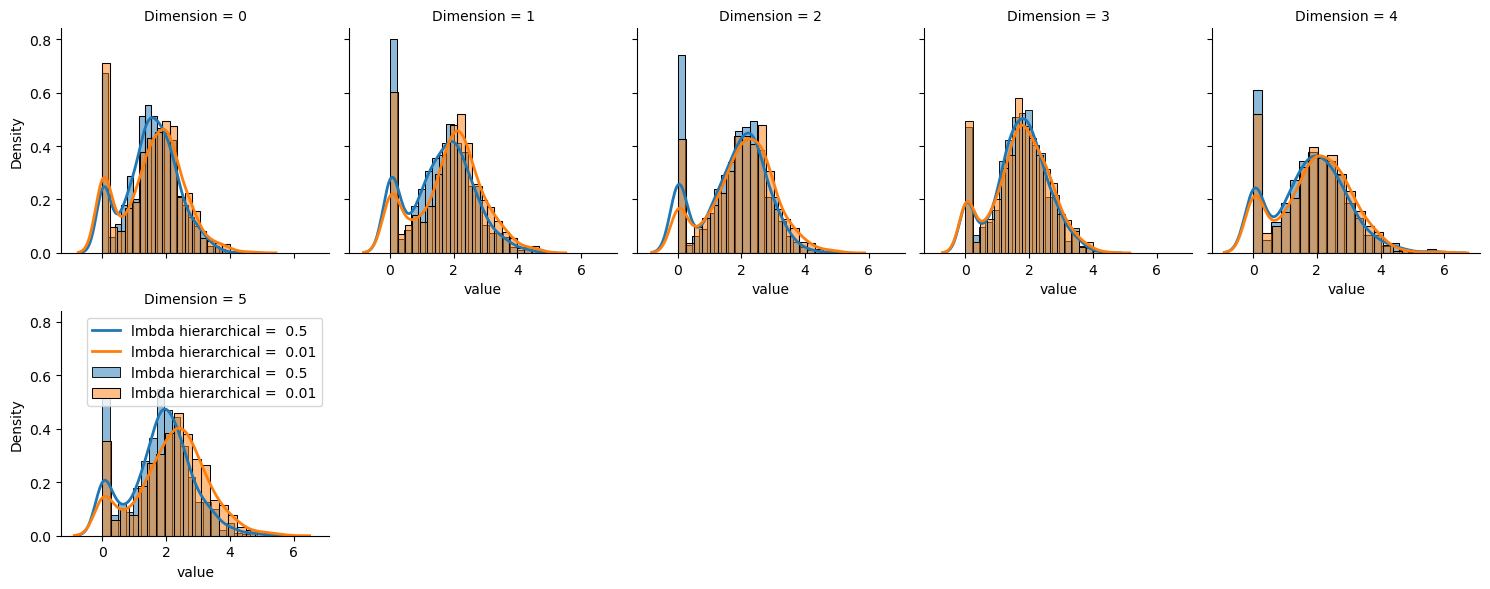

In [51]:
g = sns.FacetGrid(df_dim_weights_long_both.query("Dimension < 6"), col="Dimension", hue="modeltype", col_wrap=5)
g.map(sns.histplot, 'value', bins=20, edgecolor='black', alpha=.5, stat="density")
g.map_dataframe(sns.kdeplot, x="value", fill=False, linewidth=2, common_norm=False, weights=.5)
plt.legend()

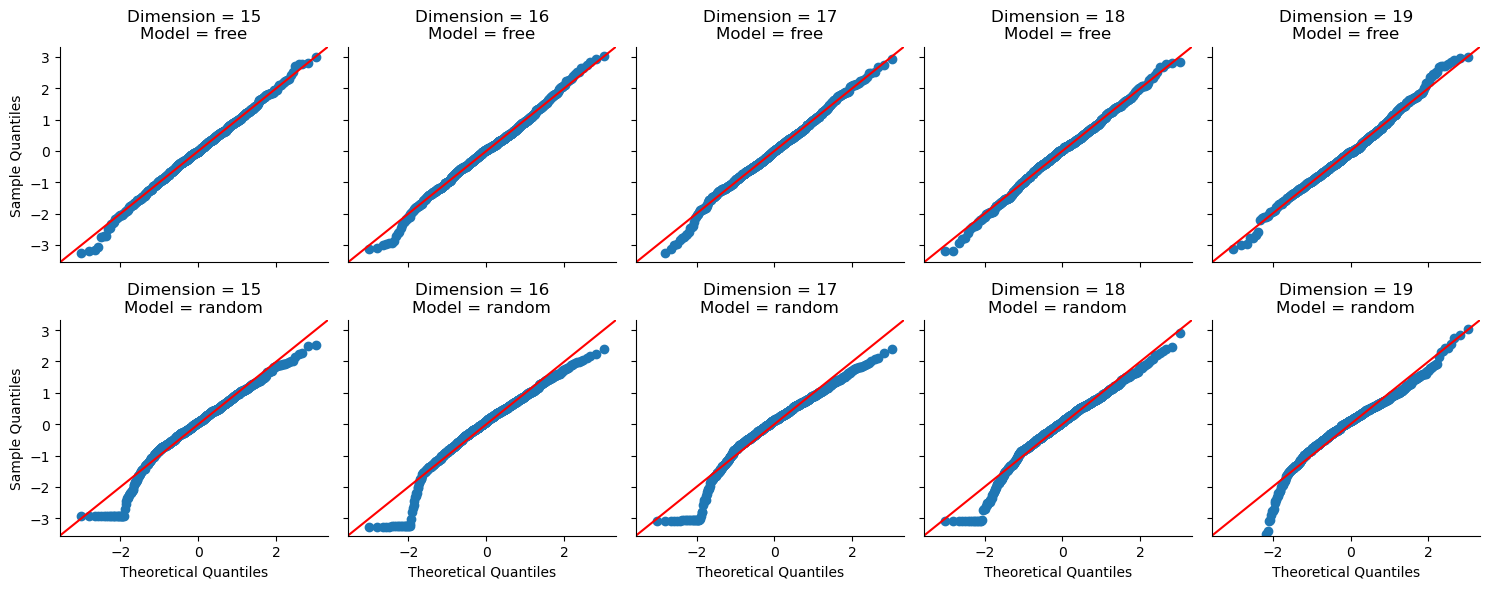

In [888]:
def qqplot_func(data, **kwargs):
    ax = plt.gca()
    sm.qqplot(data['value_z'], line='45', ax=ax)
    ax.set_title(
            f"Dimension = {data['Dimension'].iloc[0]}\nModel = {data['modeltype'].iloc[0]}"
    )
g = sns.FacetGrid(df_dim_weights_long_both.query("Dimension >= 15"), col="Dimension", row="modeltype")
_ = g.map_dataframe(qqplot_func)

#### look at item embeddings

In [859]:
df_item_embeddings_random = pd.DataFrame(
    l_models_embedding_only[0]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
df_item_embeddings_random.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.055754,2.319658,1.089947,3.134249,0.049461,2.149159,0.029957,0.031130,0.029719,0.237093,0.188704,0.419770,0.318757,0.009533,1.030119,0.095269,2.990236,1.117107,0.041715,0.048696
1,1.472499,0.364490,0.293096,0.015918,1.963307,0.009298,0.029466,0.011069,0.030740,0.349299,0.579065,1.362663,0.940541,2.012466,0.014383,0.675139,1.013987,1.759534,2.085476,0.066147
2,1.331993,0.208636,0.454848,0.037432,1.974085,0.279093,0.031364,0.030932,0.028562,0.100724,0.202354,1.538800,1.863174,1.328396,0.316774,1.448303,1.558192,0.739932,1.215645,0.447246
3,1.169118,1.290514,0.427838,0.036387,0.542115,2.539554,0.020834,0.018765,0.007593,1.053151,2.058672,0.807966,0.048364,0.887389,0.654878,0.583328,1.116544,2.330896,0.885614,0.263115
4,1.972802,0.762049,2.041713,0.048044,0.703116,0.220838,0.030512,0.000011,0.030944,0.271880,0.086408,0.876570,2.751955,1.445772,0.386767,1.474046,0.465786,0.272981,0.623834,0.300284


In [873]:
df_item_embeddings_random = pd.DataFrame(
    l_models_embedding_only[1]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
df_item_embeddings_free = pd.DataFrame(
    l_models_embedding_only[33]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
df_item_embeddings_random["item_id"] = df_item_embeddings_random.index
df_item_embeddings_random["modeltype"] = "random"
df_item_embeddings_free["item_id"] = df_item_embeddings_free.index
df_item_embeddings_free["modeltype"] = "free"

df_item_embeddings_both = pd.concat([df_item_embeddings_random, df_item_embeddings_free], axis=0)

In [874]:
df_plot = df_item_embeddings_both.drop(columns=["item_id", "modeltype"]).transform(sorted, axis=1)
df_plot["modeltype"] = df_item_embeddings_both["modeltype"].copy()
df_plot["sum_embed"] = df_plot.drop(columns="modeltype").sum(axis=1)

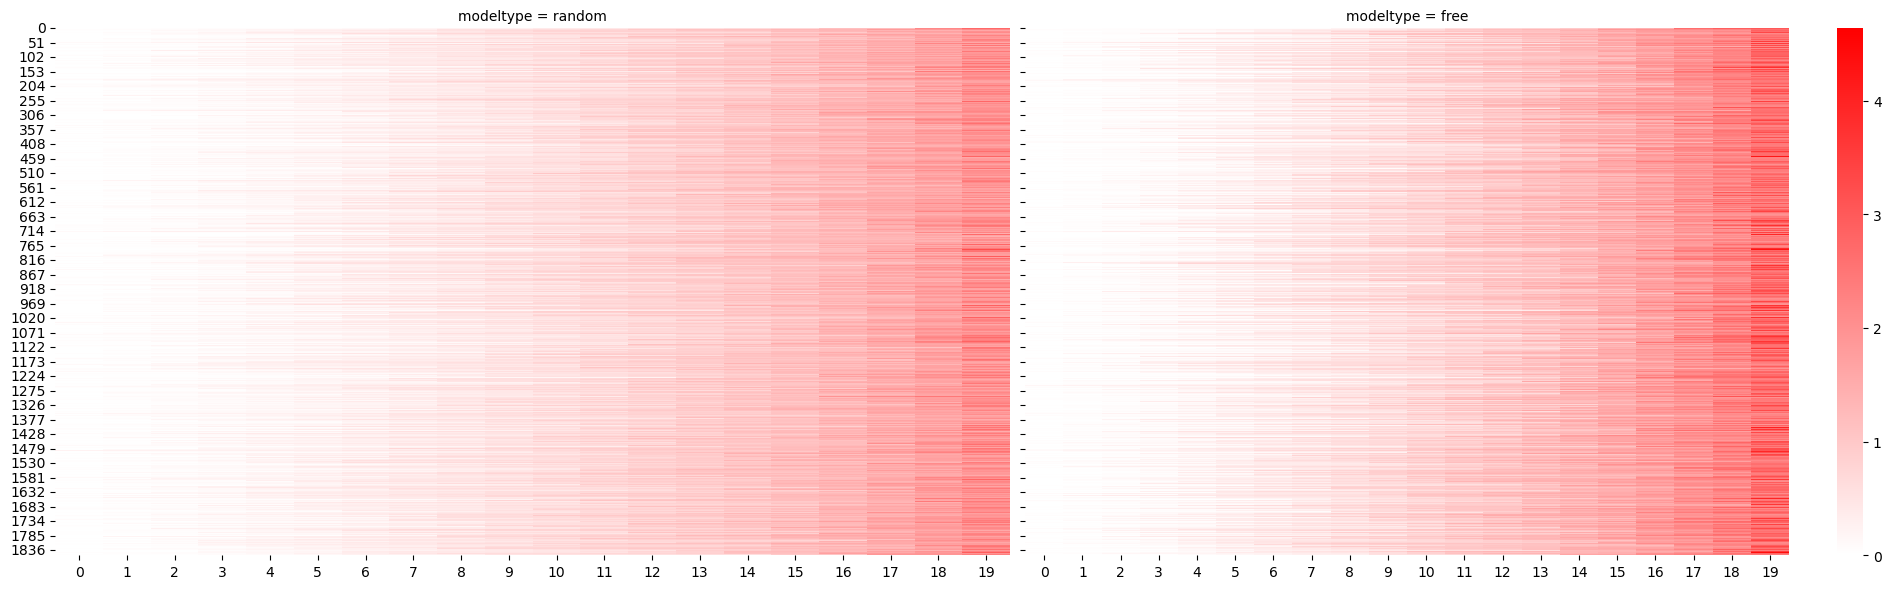

In [875]:
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap from white to red
white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
vmin = 0
vmax = df_plot.drop(columns=["modeltype", "sum_embed"]).max(axis=1).max()
height = 6
aspect = 10 / 6 # width / height = aspect

g = sns.FacetGrid(df_plot.drop(columns="sum_embed"), col="modeltype", height=height, aspect=aspect)

# Plot the heatmap
def my_heatmap(data, **kwargs):
    data_use = data.drop(columns=["modeltype"], errors='ignore')
    if data.loc[0, "modeltype"] == "free":
        sns.heatmap(data_use, cmap=white_red, ax=plt.gca(), vmin=vmin, vmax=vmax, cbar=True)
    else:
        sns.heatmap(data_use, cmap=white_red, ax=plt.gca(), vmin=vmin, vmax=vmax, cbar=False)

g.map_dataframe(my_heatmap)
plt.show()

### Compare different hierarchical lambda values

In [ ]:
###### by-participant embedding models (no by-participant decision models)
modelversion = "avg-ID-jointly-embeddings"
l_n = [6, 15]
l_temperature = [10.0]
l_subjecttype = ["subjects_actual"]
l_splithalf = ["no"]
lmbda_hierarchical = [0.01, 0.5, 5.0]
l_models_lambda_hierarchical = extract_results_id(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights",
    l_temperature=l_temperature
)

In [46]:
# cannot compare on temp = 50, even though random dim weights perform best, because free weights model performs at chance
df_dim_weights_lo_lambda = pd.DataFrame(
    l_models_lambda_hierarchical[0]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
df_dim_weights_hi_lambda = pd.DataFrame(
    l_models_lambda_hierarchical[33]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
df_dim_weights_lo_lambda["id"] = df_dim_weights_lo_lambda.index
df_dim_weights_lo_lambda_long = df_dim_weights_lo_lambda.melt(id_vars="id", var_name="Dimension")
df_dim_weights_lo_lambda_long["lambda hierarchical"] = 0.01
df_dim_weights_hi_lambda["id"] = df_dim_weights_hi_lambda.index
df_dim_weights_hi_lambda_long = df_dim_weights_hi_lambda.melt(id_vars="id", var_name="Dimension")
df_dim_weights_hi_lambda_long["lambda hierarchical"] = 5.0

df_dim_weights_lambda_long_both = pd.concat([df_dim_weights_hi_lambda_long, df_dim_weights_lo_lambda_long], axis=0)

In [47]:
# Define a function that returns two values
def summary(group):
    k2, pval = normaltest(group["value"])
    return pd.Series({
        'k2': k2,
        'pval': pval
    })

df_result_lambda = df_dim_weights_lambda_long_both.groupby(["Dimension", "modeltype"]).apply(summary).reset_index()
df_result_lambda_long = pd.melt(df_result_lambda, id_vars=["Dimension", "modeltype"])

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_17776\1412867902.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result = df_dim_weights_long_both.groupby(["Dimension", "modeltype"]).apply(summary).reset_index()


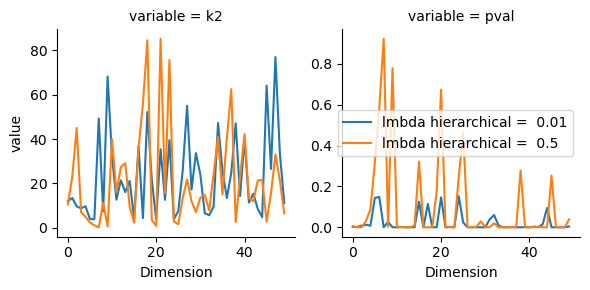

In [48]:
g = sns.FacetGrid(df_result_lambda_long, col="variable", sharey=False)
g.map_dataframe(sns.lineplot, x = "Dimension", y = "value", hue="modeltype")
_ = plt.legend()

In [49]:
df_dim_weights_lambda_long_both["value_z"] = df_dim_weights_lambda_long_both.groupby(["Dimension", "lambda hierarchical"])["value"].transform(zscore)

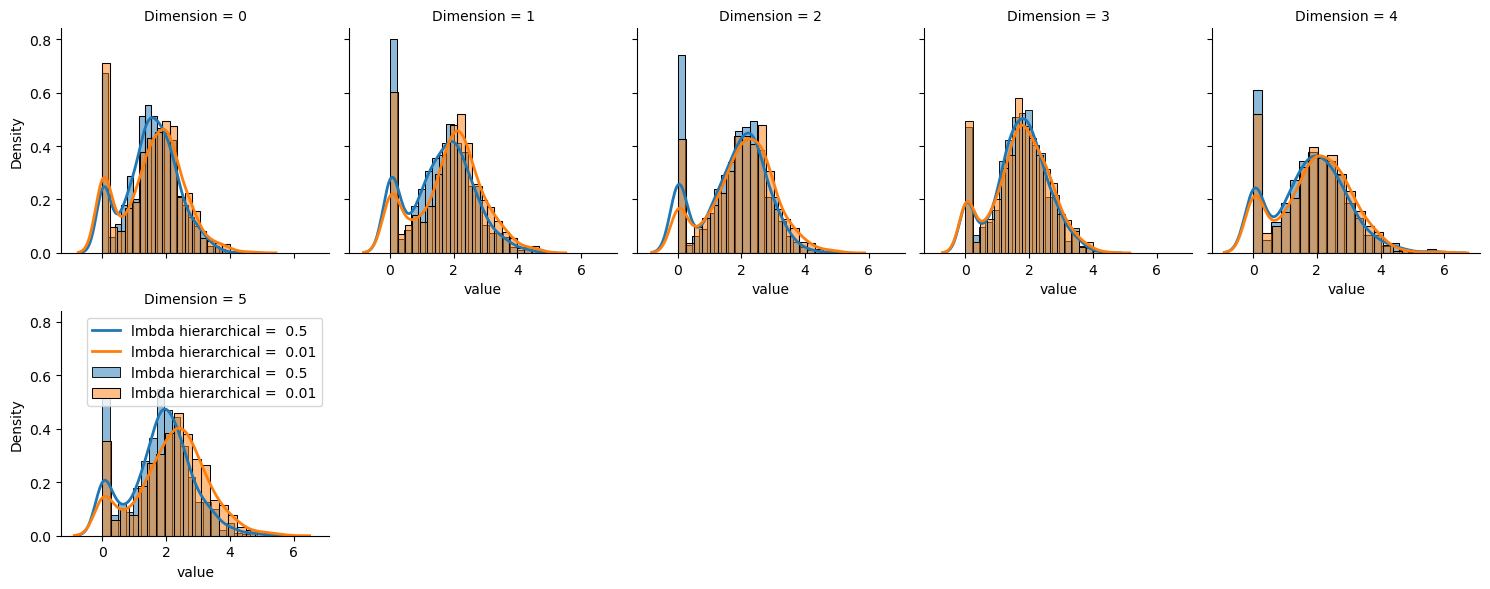

In [51]:
g = sns.FacetGrid(df_dim_weights_long_both.query("Dimension < 6"), col="Dimension", hue="lambda hierarchical", col_wrap=5)
g.map(sns.histplot, 'value', bins=20, edgecolor='black', alpha=.5, stat="density")
g.map_dataframe(sns.kdeplot, x="value", fill=False, linewidth=2, common_norm=False, weights=.5)
plt.legend()

In [59]:
def qqplot_func(data, **kwargs):
    ax = plt.gca()
    sm.qqplot(data['value_z'], line='45', ax=ax)
    ax.set_title(
            f"Dimension = {data['Dimension'].iloc[0]}\nModel = {data['lambda hierarchical'].iloc[0]}"
    )
g = sns.FacetGrid(df_dim_weights_long_both.query("Dimension >= 15"), col="Dimension", row="lambda hierarchical")
_ = g.map_dataframe(qqplot_func)

KeyError: 'lambda hierarchical'

### Compare different temperatures

merely descriptive...

#### overview embedding values for ndim = 15
for different temperatures t

- t = 10 --> 0 - 4.2
- t = 1 --> 0 - 2.2
- t = .01 --> 0 - .85

#### overview dimensional weights (average)
- t = 10 --> 2
- t = 1 --> 1
- t = .01 --> .25

--> embedding values and dimensional weights scale with temperature.

i.e., the more deterministic, the smaller both, and vice versa

In [62]:
tmp = pd.DataFrame(
    l_models_embedding_only[0]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
tmp["temp"] = 50
tmp1 = pd.DataFrame(
    l_models_embedding_only[1]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
tmp1["temp"] = 10
tmp2 = pd.DataFrame(
    l_models_embedding_only[2]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
tmp2["temp"] = 1
tmp3 = pd.DataFrame(
    l_models_embedding_only[3]["model_state_dict"]["fc.weight"].detach().numpy().transpose()
)
tmp3["temp"] = .01

df_item_embeddings = pd.concat([tmp, tmp1, tmp2, tmp3], axis=0)

In [63]:
df_item_embeddings.groupby("temp").mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
temp,,,,,,,,,,,,,,,,,,,,
0.01,0.195443,0.181602,0.159319,0.203078,0.187210,0.159059,0.161102,0.194023,0.192185,0.169977,0.171975,0.459248,0.214488,0.269699,0.196818,0.198830,0.151630,0.238658,0.155429,0.245661
1.00,0.549345,0.510066,0.324426,0.333084,0.942743,0.723456,0.482147,0.482681,0.414871,0.544609,0.302252,0.611236,0.505862,0.492984,0.606012,0.265299,0.351470,0.586655,0.392978,0.447377
10.00,0.699852,0.872130,0.459601,0.555879,1.230723,0.775034,0.580314,0.811463,0.702628,0.757114,0.583582,0.499971,0.914952,0.860814,0.707260,0.447811,0.596961,0.697903,0.630826,0.695537
50.00,1.221483,0.905492,0.974926,0.575648,0.918331,0.803954,0.022613,0.022995,0.022805,0.675650,0.796771,0.949099,0.831278,1.136742,0.918908,0.942781,0.800081,0.817192,0.842592,0.676156


In [68]:
tmp = pd.DataFrame(
    l_models_embedding_only[0]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
tmp["temp"] = 50
tmp1 = pd.DataFrame(
    l_models_embedding_only[1]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
tmp1["temp"] = 10
tmp2 = pd.DataFrame(
    l_models_embedding_only[2]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
tmp2["temp"] = 1
tmp3 = pd.DataFrame(
    l_models_embedding_only[3]["model_state_dict"]["individual_slopes.weight"].detach().numpy()
)
tmp3["temp"] = .01

df_dim_weights = pd.concat([tmp, tmp1, tmp2, tmp3], axis=0)

In [71]:
df_dim_weights.groupby("temp").mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
temp,,,,,,,,,,,,,,,,,,,,
0.01,0.189862,0.319332,0.275098,0.188753,0.197200,0.274434,0.372790,0.198579,0.151061,0.223331,0.203928,0.150301,0.187631,0.158614,0.207164,0.172306,0.208687,0.187659,0.327020,0.116934
1.00,0.929758,0.896441,1.537598,1.435571,0.818942,0.712660,0.664463,0.755469,0.923048,0.859194,1.524266,0.791467,0.872711,0.889758,0.678660,2.184688,1.614872,0.798683,1.102194,1.261901
10.00,2.100209,2.005089,2.773937,3.286489,1.865405,1.898147,3.039491,2.064404,1.997871,2.112328,2.072178,2.933445,1.897723,1.904750,1.617790,4.014515,2.330935,2.002285,2.364060,1.674401
50.00,4.418792,3.289975,3.442518,3.711457,3.918776,4.972330,1.043811,0.948569,1.024811,5.742125,3.264351,5.075516,4.778783,4.432014,3.772131,3.818019,3.895361,3.677426,3.682869,4.783727


## embedding plus decision model

### compare hyperparameter settings

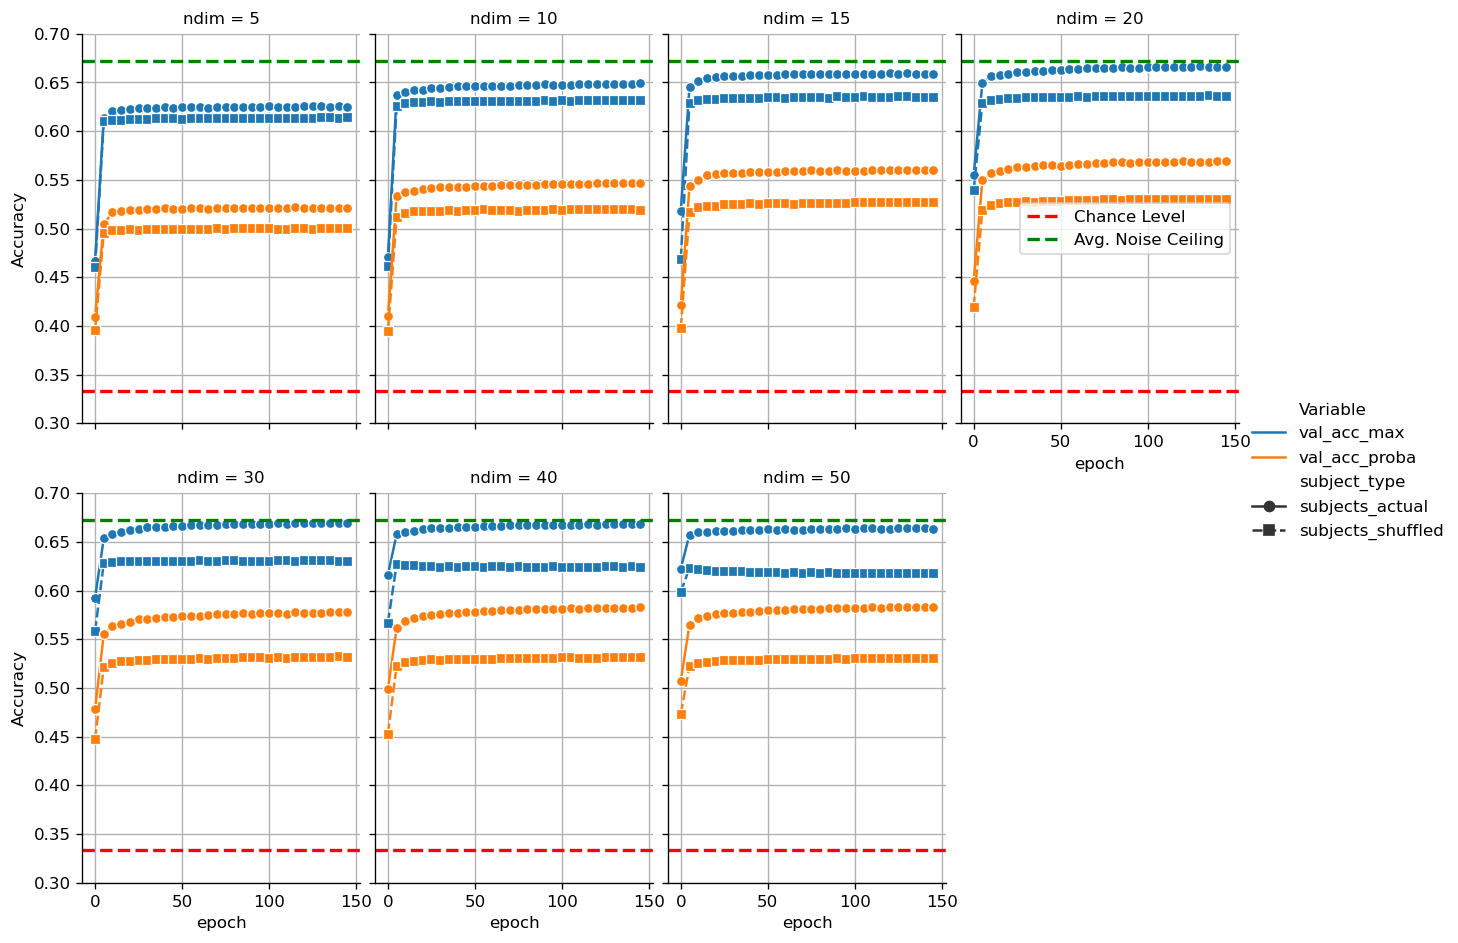

In [876]:
# Create the FacetGrid without specifying an external axis

g = sns.relplot(
    data=df_train_eval_long_id_decision.query(
        "epoch % 5 == 0 & Variable.str.contains(@substring2) & md == 'random_weights_free_scaling'",
        engine="python"
    ),
    x='epoch', y='Accuracy', col='ndim', height=4, col_wrap=4, 
    hue="Variable", style="subject_type", markers=marker_styles,
    kind="line", aspect=1
)


# Add gridlines to each facet z
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')
    ax.axhline(y=.6722, color='green', linestyle='--', linewidth=2, label='Avg. Noise Ceiling')
    ax.set_ylim(.3, .7)
    if i == 3:
        ax.legend()

plt.subplots_adjust(right=0.85)  # Increase from 0.8 to tuck it in

# Adjust the plot size
g.fig.set_size_inches(12, 8)
g.fig.set_dpi(120)

plt.show()

In [776]:
substring2 = "val_acc"
df_embedding_decision_best = df_train_eval_long_id_decision.query(
    "Variable.str.contains(@substring2)", engine="python"
).groupby(
    ["md", "subject_type", "ndim", "Variable"]
)["Accuracy"].max().reset_index()

df_embedding_decision_best = df_embedding_decision_best.pivot(
    index=["md", "subject_type", "ndim"], 
    columns=["Variable"], values="Accuracy"
).reset_index()
df_embedding_decision_best_modeltype = df_embedding_decision_best.pivot(
    index=["subject_type", "ndim"], 
    columns="md", values=["val_acc_max", "val_acc_proba"]
).reset_index()
# Assume df_pivot has MultiIndex columns after pivot
df_embedding_decision_best_modeltype.columns = [
    '_'.join(col).rstrip('_') if isinstance(col, tuple) else str(col).rstrip('_') for col in df_embedding_decision_best_modeltype.columns
]

### Distribution of by-participant decision weights

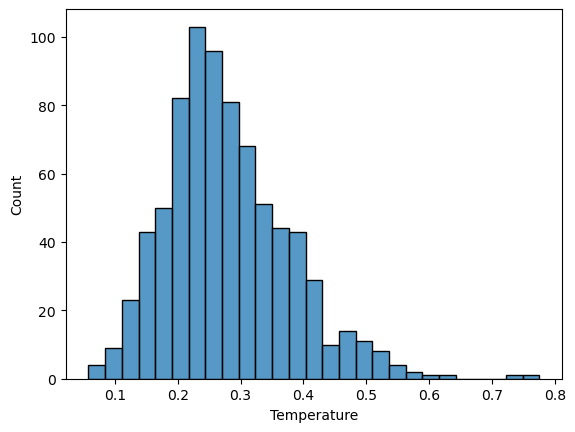

In [1010]:
df_temps_free = pd.DataFrame(
    l_models_decision[1]["model_state_dict"]["model2.individual_temps.weight"].detach().numpy()
)

df_temps_free["id"] = df_temps_free.index
df_temps_free["temp_unscaled"] = np.exp(df_temps_free[0])
sns.histplot(data=df_temps_free, x="temp_unscaled")
_ = plt.xlabel("Temperature")

## Is random worse than free? Does adding by-participant temperatures help?

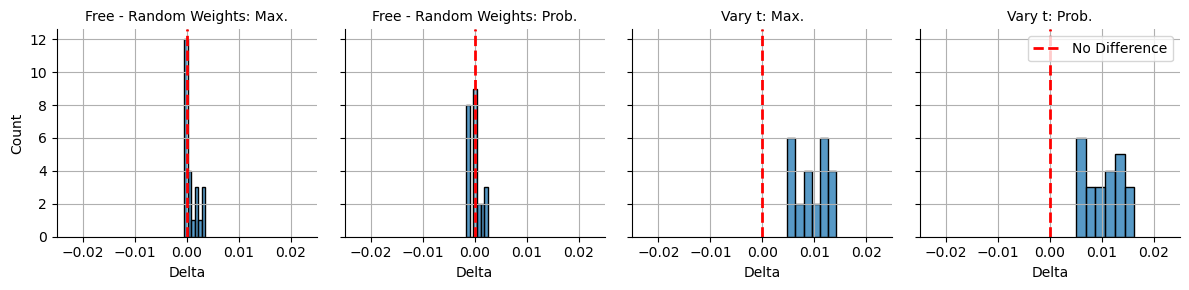

In [778]:
df_compare_models = pd.merge(
    df_embedding_best_modeltype, 
    df_embedding_decision_best_modeltype, 
    how = "left", on = ["subject_type", "ndim"]
)
df_compare_models["Free - Random Weights: Max."] = df_compare_models["val_acc_max_free_weights"] - df_compare_models["val_acc_max_random_weights"]
df_compare_models["Free - Random Weights: Prob."] = df_compare_models["val_acc_proba_free_weights"] - df_compare_models["val_acc_proba_random_weights"]
df_compare_models["Vary t: Max."] = df_compare_models["val_acc_max_random_weights_free_scaling"] - df_compare_models["val_acc_max_random_weights"]
df_compare_models["Vary t: Prob."] = df_compare_models["val_acc_proba_random_weights_free_scaling"] - df_compare_models["val_acc_proba_random_weights"]
df_hist = df_compare_models[["Free - Random Weights: Max.", "Free - Random Weights: Prob.", "Vary t: Max.", "Vary t: Prob."]].melt()
g = sns.FacetGrid(df_hist, col="variable", sharex=False)
g.map_dataframe(sns.histplot, x="value")

for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
    ax.set_xlabel("Delta")
    ax.set_xlim(-0.025, 0.025)

g.set_titles("{col_name}")  # If you just want the column name
_ = plt.legend()

*todos
- test whether increasing lambda_hierarchical does make the distribution over participants more normal (in particular, lo outlier value): in particular results on embedding only random weights ndim=15, lambda_h=0.1 vs. lambda_h=0.0005
- compare by-participant random scaling models with by-participant free scaling models

## test split-half reliability of dimensional weights

In [19]:
def extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype = "weightsonly_only_weights", l_temperature = []
):
    all_dirs = []
    l_all_results = []
    l_all_models = []
    l_sparsity = []
    l_subject = []
    l_all_splithalf = []
    for n in l_n:
        for splithalf in l_splithalf:
            for la in lmbda:
                for la_h in lmbda_hierarchical:
                    for sp in l_sparse:
                        for st in l_subjecttype:
                            if l_temperature == []:
                                results_dir_ID = os.path.join(
                                    "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}",
                                    f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                    )
                            else:
                                for temp in l_temperature:
                                    results_dir_ID = os.path.join(
                                        "./results", modelversion, f"modeltype_{modeltype}", f"splithalf_{splithalf}", f"temperature_{temp}",
                                        f'{n}d', str(la), str(la_h), sp, st, f'seed{rnd_seed}'
                                        )
                            all_dirs.append(results_dir_ID)
                            l_sparsity.append(sp)
                            l_subject.append(st)
                            l_all_splithalf.append(splithalf)
    for i, d in enumerate(all_dirs):
        file_path = os.path.join(d, 'results.json')
        l_files = os.listdir(results_dir_ID)
        latest_epoch = max_epoch(l_files)
        p = os.path.join(d, "model", latest_epoch)
        if os.path.isfile(p):
            m = torch.load(p, weights_only=True, map_location=torch.device("cpu"))
            if modeltype == "random_weights_free_scaling":
                decision_weights = m["model_state_dict"]["model1.individual_slopes.weight"]
                temperature_scalings = m["model_state_dict"]["model2.individual_temps.weight"]
                dict_out = {"decision_weights": decision_weights, "temperature_scalings": temperature_scalings}
            else:
                decision_weights = m["model_state_dict"]["individual_slopes.weight"]
                dict_out = {"decision_weights": decision_weights}
            dict_out["modeltype"] = m["modeltype"]
            dict_out["lmbda"] = m["lambda"]
            dict_out["lmbda_hierarchical"] = m["lmbda_hierarchical"]
            dict_out["n_embed"] = m["n_embed"]
            dict_out["splithalf"] = l_all_splithalf[i]
            
            l_all_models.append(dict_out)
        else:
            print(f'{p} does not exist')
    return l_all_models

In [20]:
# by-participant embedding models (no by-participant decision models)
l_temperature = [0.009999999776482582, 100.0]
l_n = [5, 10]
lmbda_hierarchical = [0.0]
modelversion = "avg-ID-jointly-embeddings"
l_sparse = ["both"]
l_splithalf = ["1", "2"]
l_subjecttype = ["subjects_actual"]
l_splithalf_1 = extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="free_weights",
    l_temperature=l_temperature
)
lmbda_hierarchical = [0.01]
l_sparse = ["items_and_random_ids"]
l_splithalf_2 = extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights",
    l_temperature=l_temperature
)
modelversion = "avg-ID-jointly-embeddings-decision"
l_n = [3, 4, 5, 6, 7, 8, 9, 10]
l_splithalf_3 = extract_split_half(
    lmbda, lmbda_hierarchical, rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights_free_scaling",
)


In [21]:
l_splithalf = l_splithalf_1 + l_splithalf_2 + l_splithalf_3

In [22]:
for i, l in enumerate(l_splithalf_3):
    print("i = ", i, ", ndim = ", l["n_embed"], ", splithalf = ", l["splithalf"])

i =  0 , ndim =  3 , splithalf =  1
i =  1 , ndim =  3 , splithalf =  2
i =  2 , ndim =  4 , splithalf =  1
i =  3 , ndim =  4 , splithalf =  2
i =  4 , ndim =  5 , splithalf =  1
i =  5 , ndim =  5 , splithalf =  2
i =  6 , ndim =  6 , splithalf =  1
i =  7 , ndim =  6 , splithalf =  2
i =  8 , ndim =  7 , splithalf =  1
i =  9 , ndim =  7 , splithalf =  2
i =  10 , ndim =  8 , splithalf =  1
i =  11 , ndim =  8 , splithalf =  2
i =  12 , ndim =  9 , splithalf =  1
i =  13 , ndim =  9 , splithalf =  2
i =  14 , ndim =  10 , splithalf =  1
i =  15 , ndim =  10 , splithalf =  2


In [23]:
def extract_decision_weights(l, tp):
    df_sh = pd.DataFrame(l["decision_weights"].detach().numpy()).reset_index(drop=False)
    df_sh = pd.melt(df_sh, id_vars=["index"], var_name='dimension', value_name='decision_weight')
    df_sh["timepoint"] = tp
    df_sh.rename(columns={"index":"id"}, inplace=True)
    return df_sh

manually select the relevant decision weight matrices and then compute the reliabilities per dimension

In [24]:
def split_half_reliabilities(l_splithalf, idxs, ndims):
    
    df_sh1 = extract_decision_weights(l_splithalf[idxs[0]], 1)
    df_sh2 = extract_decision_weights(l_splithalf[idxs[1]], 2)
    df_sh = pd.merge(df_sh1, df_sh2, how="left", on=["id", "dimension"], suffixes=["_1", "_2"])
    # Create a faceted scatterplot: one for each day
    def scatter_with_corr(data, x, y, **kwargs):
        r, _ = np.corrcoef(data[x], data[y])[0, 1], None
        z_val = data["dimension"].iloc[0]  # safely grab the facet value
        sns.scatterplot(data=data, x=x, y=y, **kwargs)
        plt.title(f"dimension = {z_val}, r = {r:.2f}")
        # Plot identity line
        min_val = min(data[x].min(), data[y].min())
        max_val = max(data[x].max(), data[y].max())
        _ = plt.plot([min_val, max_val], [min_val, max_val], color="gray", linestyle="--", linewidth=1)
        
    g = sns.FacetGrid(df_sh, col="dimension", col_wrap=5)
    g.map_dataframe(scatter_with_corr, x="decision_weight_1", y="decision_weight_2")

    df_corr = pd.DataFrame(
        df_sh.groupby("dimension").apply(lambda g: g['decision_weight_1'].corr(g['decision_weight_2'])).sort_values(ascending=False)
    )
    df_corr["ndims"] = ndims
    df_corr.columns = ["r", "ndims"]

    return df_sh, df_corr, g

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_17776\3227978693.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sh.groupby("dimension").apply(lambda g: g['decision_weight_1'].corr(g['decision_weight_2'])).sort_values(ascending=False)
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_17776\3227978693.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sh.groupby("dimension").apply(lambda g

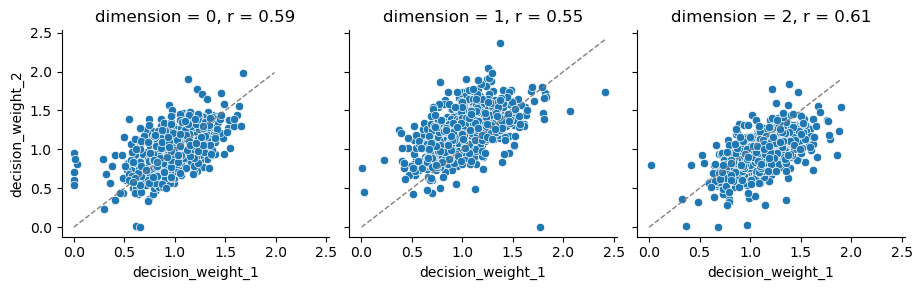

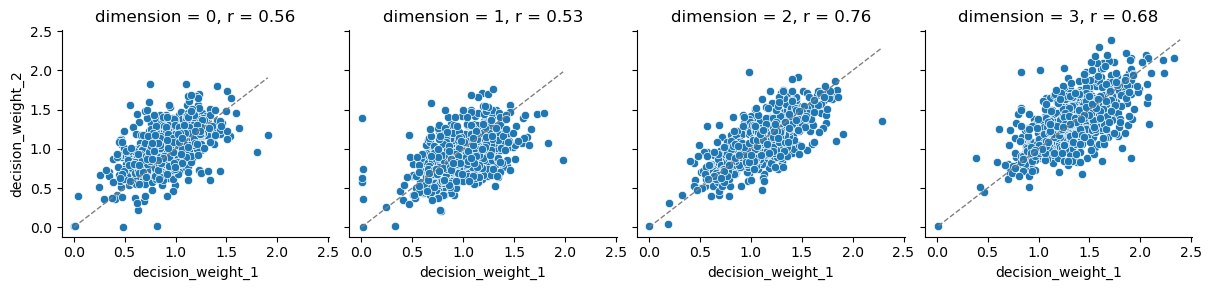

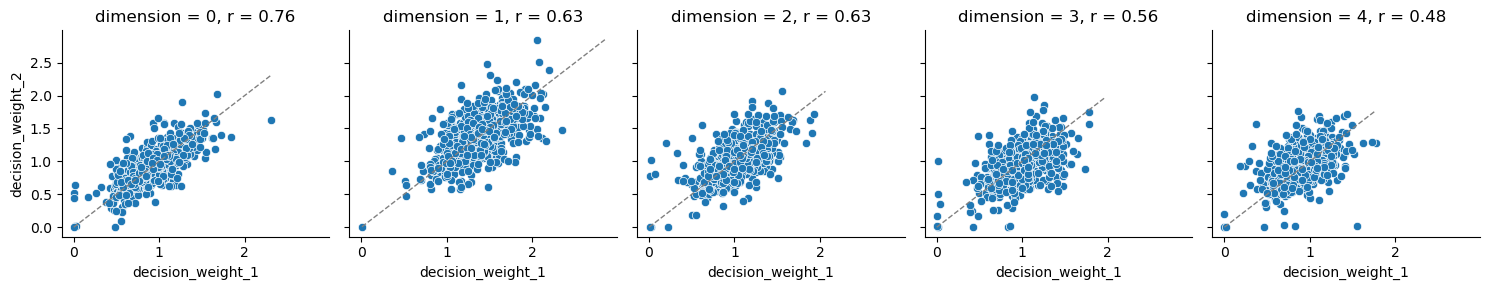

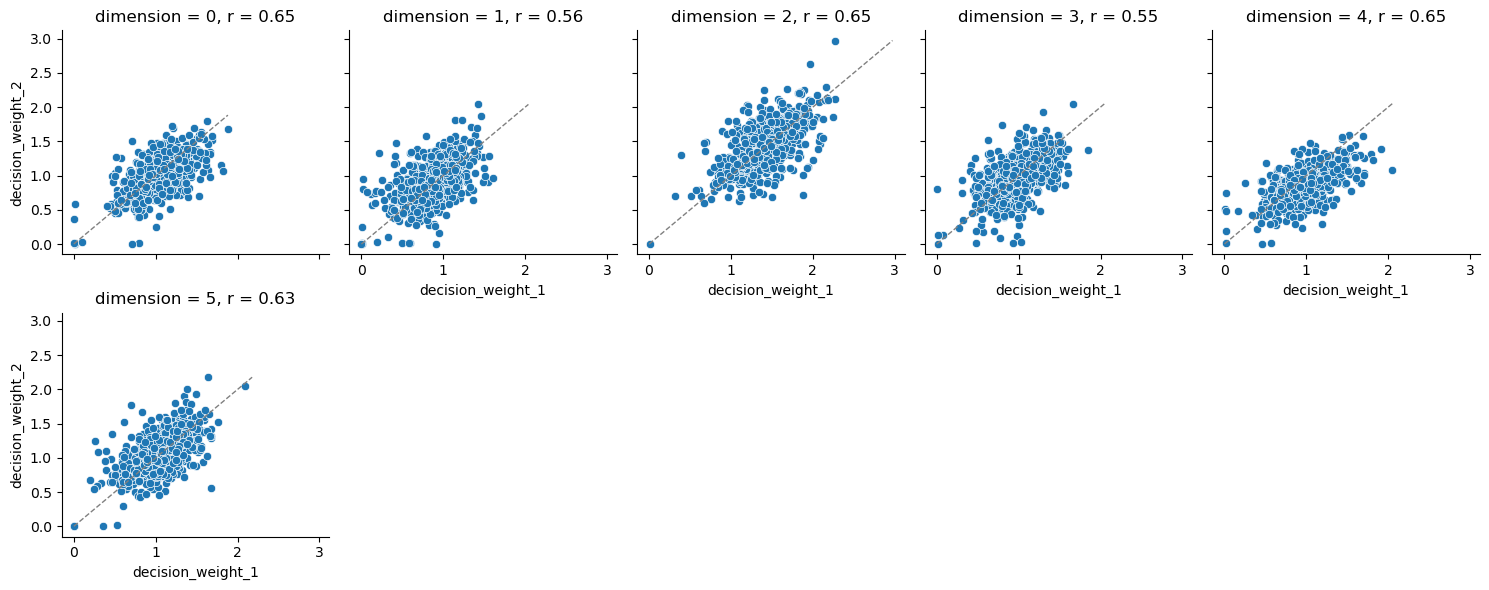

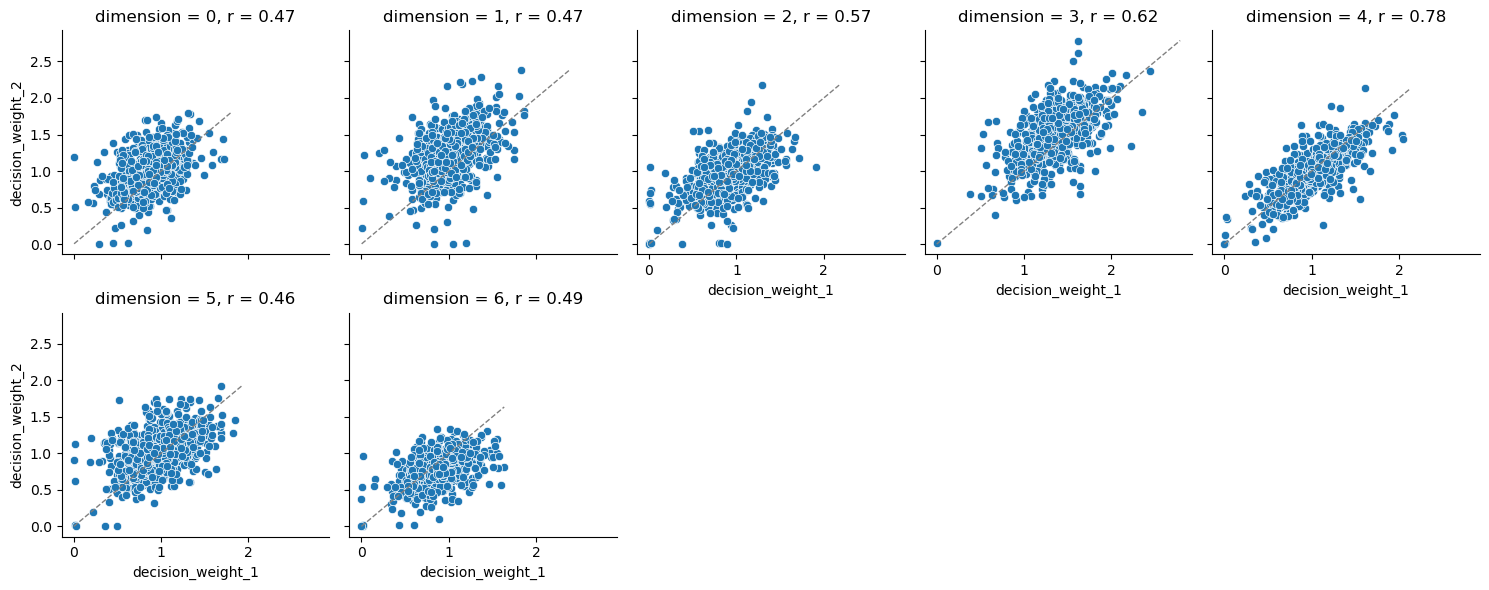

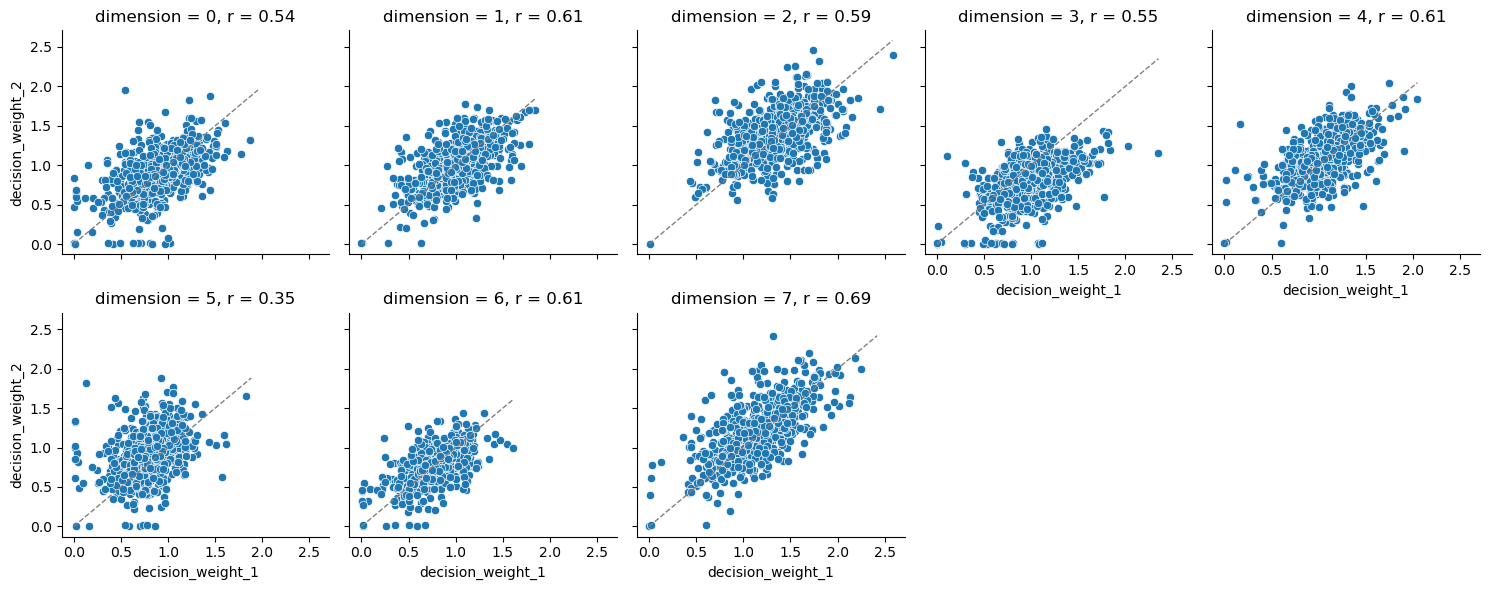

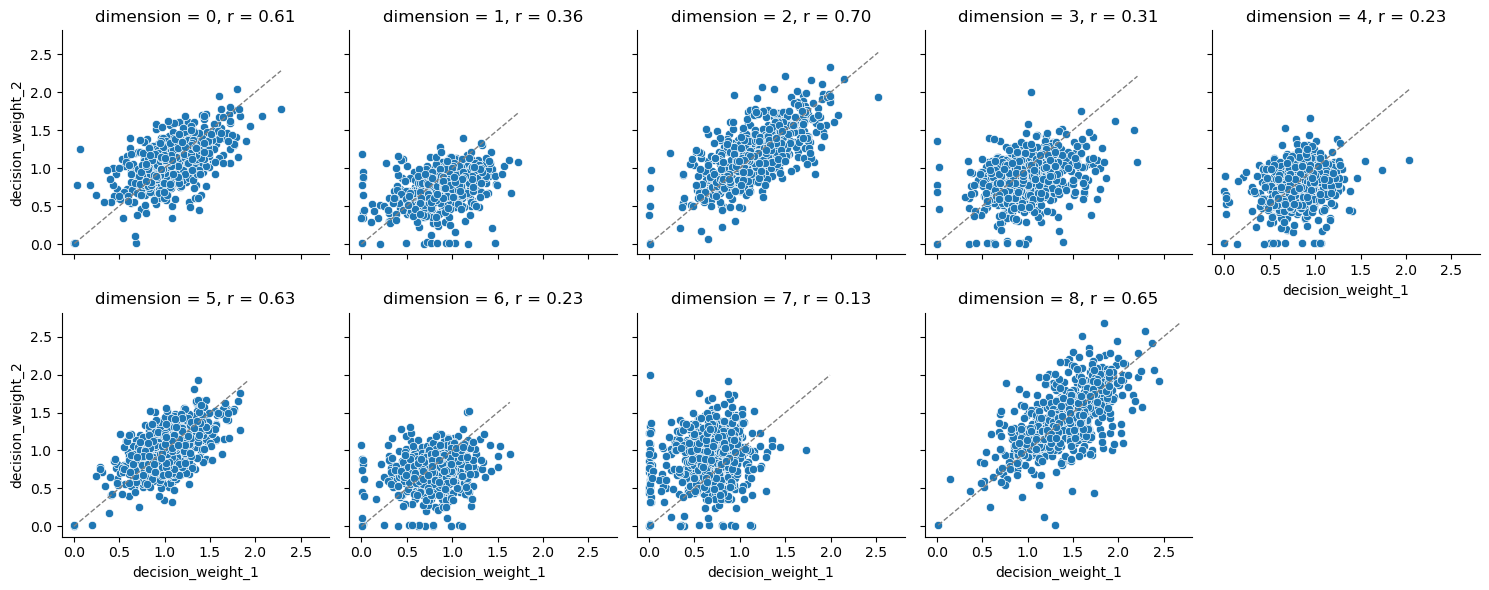

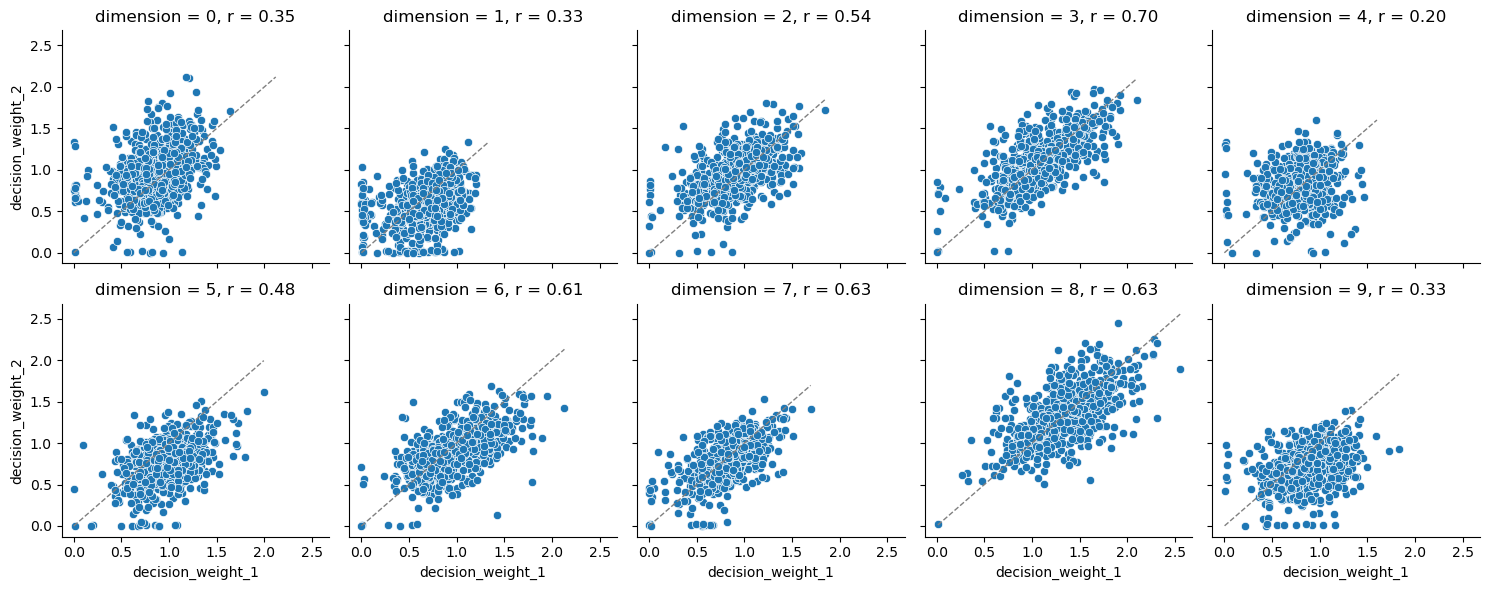

In [25]:
df_sh_3, df_corr_3, g_3 = split_half_reliabilities(l_splithalf_3, [0, 1], 3)
df_sh_4, df_corr_4, g_4 = split_half_reliabilities(l_splithalf_3, [2, 3], 4)
df_sh_5, df_corr_5, g_5 = split_half_reliabilities(l_splithalf_3, [4, 5], 5)
df_sh_6, df_corr_6, g_6 = split_half_reliabilities(l_splithalf_3, [6, 7], 6)
df_sh_7, df_corr_7, g_7 = split_half_reliabilities(l_splithalf_3, [8, 9], 7)
df_sh_8, df_corr_8, g_8 = split_half_reliabilities(l_splithalf_3, [10, 11], 8)
df_sh_9, df_corr_9, g_9 = split_half_reliabilities(l_splithalf_3, [12, 13], 9)
df_sh_10, df_corr_10, g_10 = split_half_reliabilities(l_splithalf_3, [14, 15], 10)

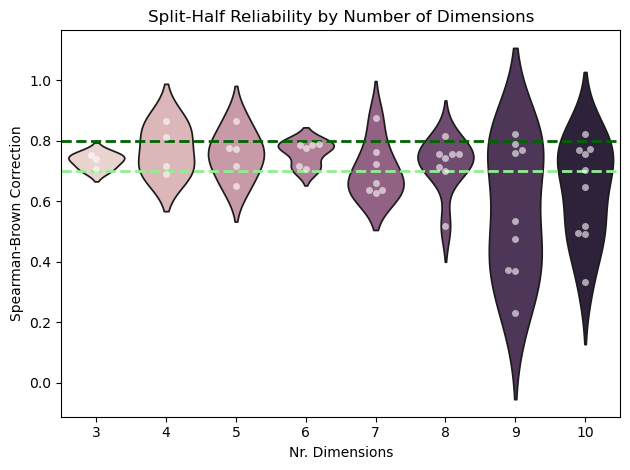

In [35]:
df_corrs = pd.concat([df_corr_3, df_corr_4, df_corr_5, df_corr_6, df_corr_7, df_corr_8, df_corr_9, df_corr_10], axis=0)
# spearman-brown prophecy correction
df_corrs["r_corrected"] = (2*df_corrs["r"])/(1 + df_corrs["r"])

# Violin plot
sns.violinplot(data=df_corrs, x="ndims", y="r_corrected", hue="ndims", inner=None)

# Swarm plot on top
sns.swarmplot(data=df_corrs, x="ndims", y="r_corrected",  color="white", alpha=0.6)

plt.axhline(y=.7, color='lightgreen', linestyle='--', linewidth=2, label='Group-Level Comparison')
plt.axhline(y=.8, color='darkgreen', linestyle='--', linewidth=2, label='Individual-Level Comparison')

plt.xlabel("Nr. Dimensions")
plt.ylabel("Spearman-Brown Correction")


# Remove duplicate legend
plt.legend([], [], frameon=False)

plt.title("Split-Half Reliability by Number of Dimensions")
plt.tight_layout()

In [29]:
df_corrs

,r,ndims,r_corrected
dimension,,,
2,0.606195,3,0.754821
0,0.587912,3,0.740485
1,0.545883,3,0.706241
2,0.762428,4,0.865202
3,0.684750,4,0.812880
0,0.558232,4,0.716494
1,0.528072,4,0.691162
0,0.763317,5,0.865774
1,0.634326,5,0.776254


In [990]:
df_sh_6["delta_decision_weight"] = df_sh_6["decision_weight_2"] - df_sh_6["decision_weight_1"]
df_sh_6["abs_delta_decision_weight"] = np.abs(df_sh_6["delta_decision_weight"])
avg_abs_delta = df_sh_6.groupby("id")["abs_delta_decision_weight"].agg("mean").reset_index()
avg_abs_delta.head()

,id,abs_delta_decision_weight
0,0,0.117076
1,1,0.126520
2,2,0.136372
3,3,0.259157
4,4,0.211222


In [991]:
df_sh_6.sort_values(["id", "dimension"]).head()

,id,dimension,decision_weight_1,timepoint_1,decision_weight_2,timepoint_2,delta_decision_weight,abs_delta_decision_weight
0,0,0,1.028980,1,1.054623,2,0.025642,0.025642
779,0,1,1.157918,1,1.003228,2,-0.154690,0.154690
1558,0,2,1.354668,1,1.577971,2,0.223303,0.223303
2337,0,3,1.092623,1,1.073394,2,-0.019230,0.019230
3116,0,4,0.812176,1,0.939031,2,0.126855,0.126855


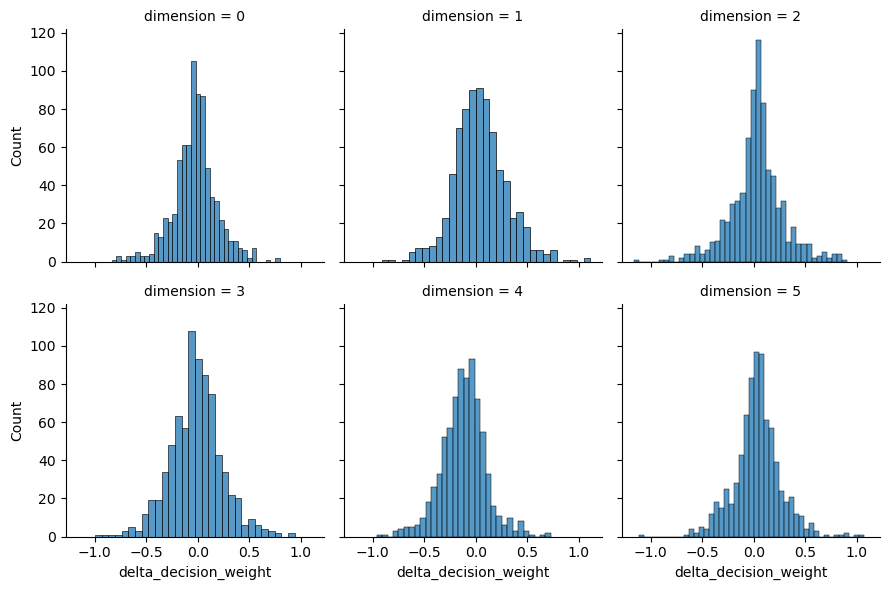

In [992]:
g = sns.FacetGrid(data=df_sh_6, col="dimension", col_wrap=3)
_ = g.map_dataframe(sns.histplot, x="delta_decision_weight")

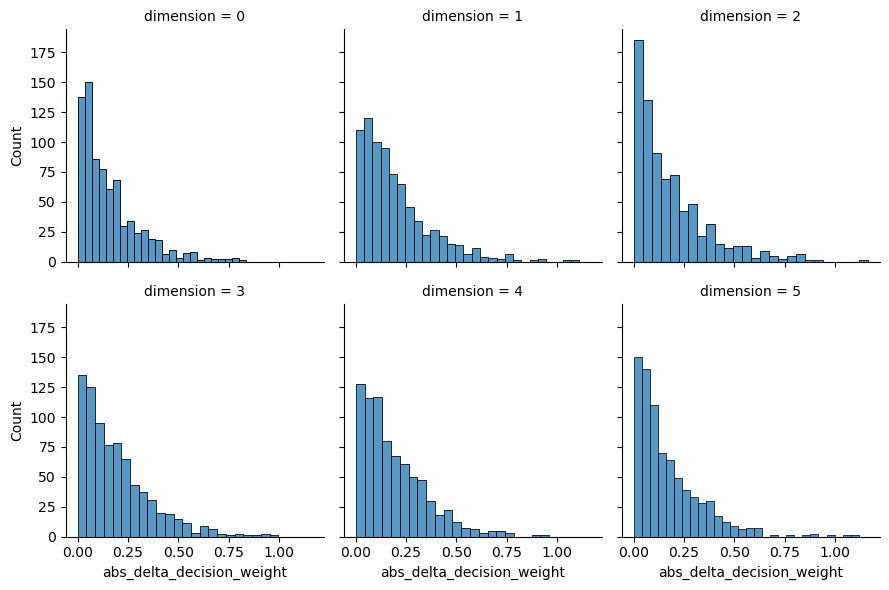

In [993]:
g = sns.FacetGrid(data=df_sh_6, col="dimension", col_wrap=3)
_ = g.map_dataframe(sns.histplot, x="abs_delta_decision_weight")

In [1001]:
# up- and downward movements in dimension weights is shared across dimensions:
icc_decision_weights = pg.intraclass_corr(data=df_sh_6, targets='id', raters='dimension', ratings='delta_decision_weight')
# distribution of weights across dimensions is quite stable across timepoints
# i.e., either you weigh equally all the time, or you up- and downweigh equally across splits
ginis = df_sh_6.groupby("id")[["decision_weight_1", "decision_weight_2"]].agg(ut.gini).reset_index()
icc_ginis = pg.intraclass_corr(data=ginis.melt(id_vars="id"), targets='id', raters='variable', ratings='value')
# given gini coef is stable across sessions, let us just take the average:
ginis_avg = ginis[["decision_weight_1", "decision_weight_2"]].mean(axis=1).reset_index()
ginis_avg["id"] = ginis["id"].copy()
ginis_avg.drop(columns="index", inplace=True)
ginis_avg.columns = ["avg_gini", "id"]
ginis_avg = ginis_avg[["id", "avg_gini"]]
# merge gini with abs deltas: are they positively related? i.e., larger changes lead to larger dimensional inequality?
df_gini_abs_delta = pd.merge(ginis_avg, avg_abs_delta, on="id", how="left")
# seems to be the case, but effect is rather small (see bivariate plot below)

In [1002]:
icc_decision_weights.query("Type == 'ICC3'")

,Type,Description,ICC,F,df1,df2,pval,CI95%
2,ICC3,Single fixed raters,0.518574,7.462973,778,3890,0.0,"[0.49, 0.55]"


In [1003]:
icc_ginis.query("Type == 'ICC3'")

,Type,Description,ICC,F,df1,df2,pval,CI95%
2,ICC3,Single fixed raters,0.732214,6.468638,778,778,3.280050e-132,"[0.7, 0.76]"


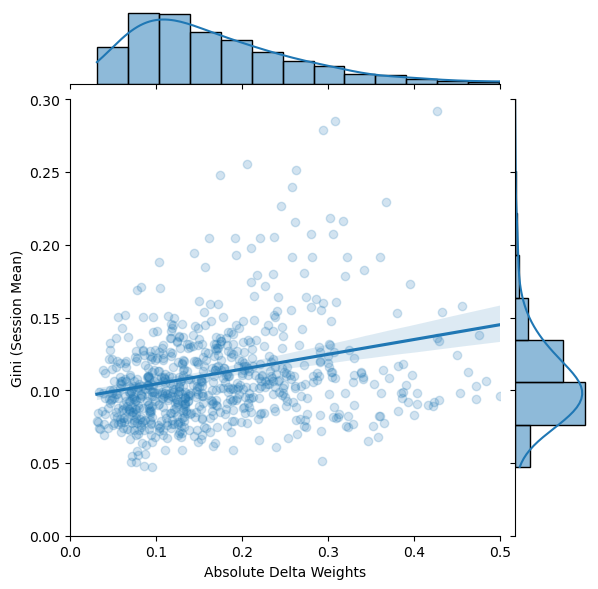

In [1005]:
sns.jointplot(
    data=df_gini_abs_delta,
    x="abs_delta_decision_weight",
    y="avg_gini",
    kind="reg",
    marginal_kws=dict(bins=20, fill=True),
    joint_kws=dict(scatter_kws={'alpha': 0.2})  # Specifically for the points
)
plt.ylim((0, .3))
plt.xlim((0, .5))
plt.ylabel("Gini (Session Mean)")
_ = plt.xlabel("Absolute Delta Weights")

In [984]:
pd.merge(
    df_sh_6, ginis_avg, on="id", how="left"
).pivot(
    index=["id", "avg_gini"], columns="dimension", values=["decision_weight_1", "decision_weight_2"]
).sort_values("avg_gini")

decision_weight_1                                          \
dimension                    0         1         2         3         4   
id  avg_gini                                                             
389 0.047287          1.178498  1.088480  1.315002  1.211793  1.237539   
630 0.047978          1.214196  1.100784  1.479241  1.199866  1.260519   
700 0.050446          1.058956  1.021718  1.150352  0.988444  0.922805   
299 0.050771          1.224896  1.311400  1.636014  1.292934  1.358714   
553 0.051622          1.097211  1.031016  1.316810  1.229427  1.284372   
...                        ...       ...       ...       ...       ...   
589 0.379810          0.780110  0.567188  1.457219  0.579362  0.451987   
722 0.409561          0.101354  0.326384  0.951180  0.016120  0.861579   
667 0.495214          0.001076  0.012843  1.461062  0.481836  0.914477   
137 0.582010          0.796927  0.011063  1.263463  1.080182  0.016441   
619 0.629374          0.013690  0.579741  0.320148  0.012262  0.021248   

                       decision_weight_2                                \
dimension            5                 0         1         2         3   
id  avg_gini                                                             
389 0.047287  1.287187          1.058651  1.147407  1.364691  1.285530   
630 0.047978  1.174230          1.190077  1.235816  1.522558  1.290478   
700 0.050446  1.008402          0.999619  0.961203  1.140583  1.063150   
299 0.050771  1.278843          1.401950  1.237167  1.614085  1.312297   
553 0.051622  1.199042          0.895464  0.772754  1.012000  0.943361   
...                ...               ...       ...       ...       ...   
589 0.379810  0.002063          0.515533  0.305062  1.215750  0.520786   
722 0.409561  0.792441          0.034018  0.827935  1.035286  0.137972   
667 0.495214  1.006486          0.012740  0.001199  1.635799  0.015314   
137 0.582010  0.009543          0.013716  0.009843  0.714153  0.967033   
619 0.629374  0.793896          0.021266  0.014577  0.706506  0.000222   

                                  
dimension            4         5  
id  avg_gini                      
389 0.047287  1.064139  1.383303  
630 0.047978  1.162115  1.300851  
700 0.050446  0.755041  1.061796  
299 0.050771  1.201553  1.268208  
553 0.051622  0.791413  0.983374  
...                ...       ...  
589 0.379810  0.301895  0.010490  
722 0.409561  0.300120  0.664119  
667 0.495214  1.309825  1.187960  
137 0.582010  0.187234  0.001732  
619 0.629374  0.015070  1.276351  

[779 rows x 12 columns]

Evaluate winning model against best avg model

In [1007]:
df_id_best = df_train_eval_long_id.query(
    "`lambda` == 0.0005 & ndim == 15 & subject_type == 'subjects_actual'"
).copy()
df_id_best["id_level"] = "ID"

NameError: name 'df_train_eval_long_id' is not defined

In [1008]:
# Create the FacetGrid without specifying an external axis
g = sns.relplot(
    data=df_train_eval_long_avg.query("epoch <= 749 & epoch % 25 == 0"), x='epoch', y='Accuracy', 
    col='ndim', row="lambda", height=4, hue="Variable",
    marker="o", aspect=1, kind="line")
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')
    
    #ax.set_xlim(0, 400)
    ax.set_ylim(0, 1)
    if i == 0:
        ax.legend()

# Adjust the plot size
g.fig.set_size_inches(8, 4)
g.fig.set_dpi(150)

plt.show()

NameError: name 'df_train_eval_long_avg' is not defined

In [ ]:
df_avg_best = df_train_eval_long_avg.query("`lambda` == 0.0005 & ndim == 15").copy()
df_avg_best["id_level"] = "avg"

In [ ]:
cols_shared = np.intersect1d(df_id_best.columns, df_avg_best.columns)
df_best_both = pd.concat([df_id_best[cols_shared], df_avg_best[cols_shared]])

In [ ]:
# Create the FacetGrid without specifying an external axis
palette = sns.color_palette("Set2")[2:]
g = sns.relplot(
    data=df_best_both.query("Variable == 'val_acc' & epoch <= 100"), x='epoch', y='Accuracy', 
    height=4, hue="id_level", palette=palette,
    marker="o", aspect=1, kind="line")
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    #ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')
    
    #ax.set_xlim(0, 400)
    ax.set_ylim(.59, .64)
    if i == 0:
        ax.legend()

# Adjust the plot size
g.fig.set_size_inches(8, 5)
g.fig.set_dpi(150)

plt.show()

In [ ]:
l_all_models_id[3]["model_state_dict"]["fc.weight"].shape

In [ ]:
l_all_models_id[3]["model_state_dict"]["individual_slopes.weight"].shape

# Comparison per Participant

In [121]:
for i, l in enumerate(l_all_models_id_1):
    print("i = ", i)
    print("n_embed = ", l["n_embed"])
    print("subject_type = ", l["subject_type"], "\n")

i =  0
n_embed =  5
subject_type =  subjects_actual 

i =  1
n_embed =  5
subject_type =  subjects_shuffled 

i =  2
n_embed =  10
subject_type =  subjects_actual 

i =  3
n_embed =  10
subject_type =  subjects_shuffled 

i =  4
n_embed =  15
subject_type =  subjects_actual 

i =  5
n_embed =  15
subject_type =  subjects_shuffled 

i =  6
n_embed =  20
subject_type =  subjects_actual 

i =  7
n_embed =  20
subject_type =  subjects_shuffled 

i =  8
n_embed =  30
subject_type =  subjects_actual 

i =  9
n_embed =  30
subject_type =  subjects_shuffled 

i =  10
n_embed =  40
subject_type =  subjects_actual 

i =  11
n_embed =  40
subject_type =  subjects_shuffled 

i =  12
n_embed =  50
subject_type =  subjects_actual 

i =  13
n_embed =  50
subject_type =  subjects_shuffled 



In [122]:
triplets_dir = './data/'
device = "cpu"
# load triplets into memory
train_triplets, test_triplets = ut.load_data_ID(
    device=device, triplets_dir=triplets_dir, testcase=False)


...Could not find any .npy files for current modality.
...Now searching for .txt files.



In [128]:
# model with 30 dims
array_weights_items = np.array(l_all_models_id_1[8]["model_state_dict"]["model1.fc.weight"]).transpose()
array_weights_id = l_all_models_id_1[8]["model_state_dict"]["model1.individual_slopes.weight"]

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1834385748.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  array_weights_items = np.array(l_all_models_id_1[8]["model_state_dict"]["model1.fc.weight"]).transpose()


In [129]:
anchors = torch.Tensor(np.array([array_weights_items[i,:] for i in list(test_triplets[:, 0])]))
positives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(test_triplets[:, 1])]))
negatives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(test_triplets[:, 2])]))

In [576]:
anchors = np.array([array_weights_items[i,:] for i in list(test_triplets[:, 0])])
positives = np.array([array_weights_items[i,:] for i in list(test_triplets[:, 1])])
negatives = np.array([array_weights_items[i,:] for i in list(test_triplets[:, 2])])

In [131]:
ids = test_triplets[:, 3].numpy()

In [132]:
anchors_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(anchors)]
positives_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(positives)]
negatives_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(negatives)]

In [133]:
from functools import partial

In [134]:
f_partial = partial(ut.delta_avg_id, anchors, positives, negatives, anchors_weighted, positives_weighted, negatives_weighted, ids)

In [135]:
ids_unique_sorted = np.sort(np.unique(ids))

In [136]:
l_deltas = list(map(f_partial, ids_unique_sorted))

In [146]:
deltas_participant = []
for l in l_deltas:
    deltas_participant.append(l[0])

In [147]:
df_ns = pd.DataFrame(ids, columns=['id'])
df_ns = df_ns.groupby("id")["id"].count() * 4
df_ns = df_ns.reset_index(name = "n_train")
df_ns["delta"] = deltas_participant

In [148]:
df_ns.to_csv("data/deltas-learned-weighted-embeddings.csv")

In [794]:
df_ns.head()

,id,n_train,delta
0,0,2048,0.062500
1,1,256,0.000000
2,2,560,0.035714
3,3,832,0.033654
4,4,240,0.000000


In [808]:
import statsmodels.api as sm
import seaborn as sns

In [810]:
import statsmodels.api as sm
print(sm.__version__)


0.14.4


In [1034]:
df_ns["is_improvement"] = (df_ns["delta"] >= 0).astype(int)
prop_triplets_improved = np.round(np.mean(df_ns["is_improvement"], axis=0), 4)
prop_triplets_improved

np.float64(0.8703)

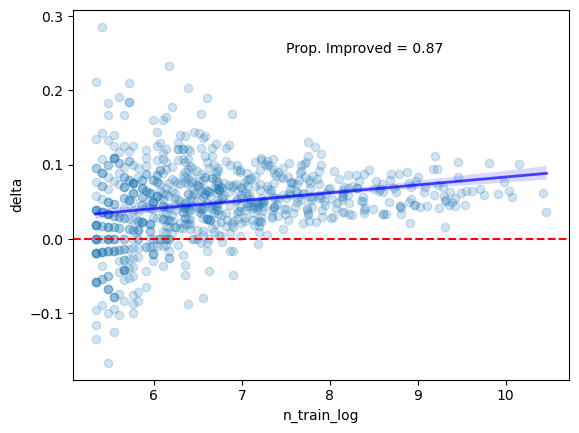

In [1028]:
df_ns["n_train_log"] = np.log(df_ns["n_train"])
_ = sns.regplot(
    data=df_ns,
    x="n_train_log",
    y="delta",
    scatter=True,  # Set to False if you only want the smooth line, not the scatter
    line_kws={"color": "blue", "lw": 2, "alpha": .7}, 
    scatter_kws={"alpha": .2}
)
plt.axhline(y=0, color="red", linestyle="--", label="No Improvement")
_ = plt.text(x=7.5, y=.25, s=f"Prop. Improved = {prop_triplets_improved}")

In [1030]:
df_ns.sort_values("delta", ascending=False)

,id,n_train,delta,n_train_log,is_improvement
419,419,224,0.285714,5.411646,1
624,624,480,0.233333,6.173786,1
648,648,208,0.211538,5.337538,1
629,629,304,0.210526,5.717028,1
589,589,592,0.202703,6.383507,1
...,...,...,...,...,...
362,362,272,-0.102941,5.605802,0
684,684,208,-0.115385,5.337538,0
588,588,256,-0.125000,5.545177,0
187,187,208,-0.134615,5.337538,0


# Analyze Improvements of Individual Models over Triplet Agreement

In [514]:
df_diagnostic = pd.read_csv("data/diagnostic-triplets.csv")

In [1016]:
df_diagnostic

,id_lo,id_mid,id_hi,n
0,0,146,1534,102
1,0,176,1227,114
2,0,192,1088,17
3,0,688,1307,110
4,1,502,1157,106
...,...,...,...,...
1982,1538,1654,1757,17
1983,1542,1698,1804,19
1984,1546,1639,1696,16
1985,1549,1606,1755,108


In [1015]:
df_train_test.head()

,0,1,2,id_subject,id_lo,id_mid,id_hi
0,840,839,1732,0,839,840,1732
1,1512,367,1769,0,367,1512,1769
2,1733,1303,1126,0,1126,1303,1733
3,1092,1448,826,0,826,1092,1448
4,867,128,1137,0,128,867,1137


In [542]:
df_test_triplets = pd.DataFrame(test_triplets)
df_train_triplets = pd.DataFrame(train_triplets)
df_train_test = pd.concat([df_train_triplets, df_test_triplets], axis=0)

In [549]:
cols = [0, 1, 2]
vals = df_train_test[cols].to_numpy()

# Compute lo, hi, and mid values using vectorized operations
id_lo = np.min(vals, axis=1)
id_hi = np.max(vals, axis=1)

# Calculate id_mid: total - min - max
id_sum = vals.sum(axis=1)
id_mid = id_sum - id_lo - id_hi

# Assign to the DataFrame
df_train_test['id_lo'] = id_lo
df_train_test['id_mid'] = id_mid
df_train_test['id_hi'] = id_hi

df_train_test.rename(columns={3:"id_subject"}, inplace=True)
# filter diagnostic triplets from choices
df_diagnostic_data = pd.merge(df_diagnostic, df_train_test, how="inner", on=["id_lo", "id_mid", "id_hi"])

In [606]:
# Create a string-based triplet_id column from id_lo, id_mid, id_hi
df_diagnostic_data["triplet_id"] = (
    df_diagnostic_data[["id_lo", "id_mid", "id_hi"]]
    .astype(str)
    .agg("".join, axis=1)  # concatenate values without separators
)
df_diagnostic_data["triplet_id"] = pd.Categorical(df_diagnostic_data["triplet_id"])
# Convert to categorical and assign integer labels starting from 1
df_diagnostic_data["triplet_id"] = (
    pd.Categorical(df_diagnostic_data["triplet_id"])
    .rename_categories(lambda x: str(df_diagnostic_data["triplet_id"].cat.categories.get_loc(x) + 1))
)

In [779]:
anchors = torch.Tensor(np.array([array_weights_items[i,:] for i in list(df_diagnostic_data.loc[:, 0])]))
positives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(df_diagnostic_data.loc[:, 1])]))
negatives = torch.Tensor(np.array([array_weights_items[i,:] for i in list(df_diagnostic_data.loc[:, 2])]))

In [780]:
anchors_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(anchors)]
positives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(positives)]
negatives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(negatives)]

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1006436363.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anchors_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(anchors)]
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1006436363.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  positives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(positives)]
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\1006436363.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  negatives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate

In [759]:
df_items_delta = ut.delta_avg_triplet(
    anchors, positives, negatives, anchors_weighted, positives_weighted, negatives_weighted, 
    array_weights_items, array_weights_id, df_diagnostic_data
)
labels_accuracy_binned = pd.cut(df_items_delta["correct_avg"], 10)

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\3534149701.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anchors_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(anchors)]
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\3534149701.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  positives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate(positives)]
C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\3534149701.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  negatives_weighted = [a*array_weights_id.numpy()[df_diagnostic_data.loc[id, "id_subject"]] for id, a in enumerate

In [1032]:
df_items_delta.head()

,triplet_id,correct_avg,correct_id,n,delta,Accuracy Avg. Model
0,1,0.860215,0.849462,93,-0.010753,8
1,2,0.780000,0.730000,100,-0.050000,7
2,3,0.666667,0.833333,6,0.166667,6
3,4,0.803922,0.803922,102,0.000000,8
4,5,0.400000,0.600000,110,0.200000,3


In [1035]:
df_items_delta["is_improvement"] = (df_items_delta["delta"] >= 0).astype(int)
prop_triplets_improved = np.round(np.mean(df_items_delta["is_improvement"], axis=0), 3)
prop_triplets_improved

np.float64(0.876)

select triplets:
- based on data set with several responses per triplet
- based on whether predictions from two models disagree

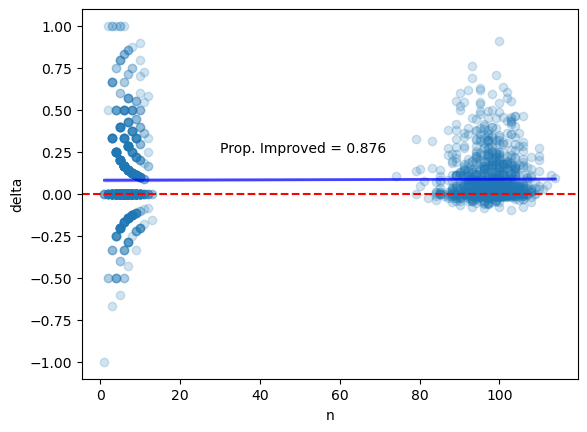

In [1037]:
_ = sns.regplot(
    data=df_items_delta,
    x="n",
    y="delta",
    scatter=True,  # Set to False if you only want the smooth line, not the scatter
    line_kws={"color": "blue", "lw": 2, "alpha": .7}, 
    scatter_kws={"alpha": .2}
)
plt.axhline(y=0, color="red", linestyle="--", label="No Improvement")
_ = plt.text(x=30, y=.25, s=f"Prop. Improved = {prop_triplets_improved}")

In [767]:
# Group by 'correct_avg_bin' and compute the weighted average of 'delta'
df_summary = (
    df_items_delta.groupby(["Accuracy Avg. Model"])
    .apply(lambda g: pd.Series({
        "Delta": (g["delta"] * g["n"]).sum() / g["n"].sum(),
        "Total Nr. Responses": g["n"].sum()
    }))
    .reset_index()
)
df_summary["Proportion Responses"] = df_summary["Total Nr. Responses"] / df_summary["Total Nr. Responses"].sum(axis=0)
df_summary["Proportion Delta"] = df_summary["Proportion Responses"] * df_summary["Delta"]

C:\Users\MirkoThalmann\AppData\Local\Temp\ipykernel_14040\2055925853.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


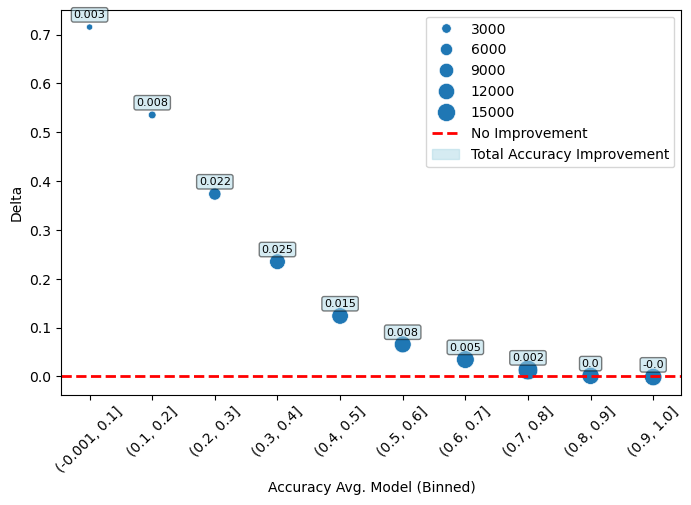

In [770]:
# Step 1: Generate your plot
f, ax = plt.subplots(1, 1, figsize=(8, 5))
scatter = sns.scatterplot(
    data=df_summary,
    x="Accuracy Avg. Model",
    y="Delta",
    size="Total Nr. Responses",
    sizes=(20, 200),
    legend='brief',
    ax=ax, 
)
ax.set_xlabel("Accuracy Avg. Model (Binned)")
# Step 2: Horizontal line with label
ax.axhline(y=0, color="red", linestyle='--', linewidth=2, label='No Improvement')

# Step 3: Add text labels
for i, row in df_summary.iterrows():
    ax.text(
        row["Accuracy Avg. Model"],
        row["Delta"] + 0.025,
        f"{str(np.round(row['Proportion Delta'], 3))}",
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(boxstyle="round,pad=0.2", fc="lightblue", alpha=0.5)
    )

# Step 4: Create a proxy handle for the ax.text labels
label_proxy = mpatches.Patch(color='lightblue', alpha=0.5, label='Accuracy Improvement')

# Step 5: Combine all handles
handles, labels = ax.get_legend_handles_labels()
handles.append(label_proxy)
labels.append('Total Accuracy Improvement')

# Step 6: Show legend with all entries
ax.legend(handles=handles, labels=labels)

_ = plt.xticks(ticks=range(len(labels_accuracy_binned.cat.categories)),
           labels=labels_accuracy_binned.cat.categories, rotation=45)

In [1019]:
df_items_delta.query("n >= 10").sort_values("delta", ascending=False)

,triplet_id,correct_avg,correct_id,n,delta,Accuracy Avg. Model
990,991,0.040000,0.950000,100,0.910000,0
458,459,0.000000,0.900000,10,0.900000,0
1222,1223,0.000000,0.800000,10,0.800000,0
246,247,0.075269,0.838710,93,0.763441,0
1125,1126,0.090909,0.818182,11,0.727273,0
...,...,...,...,...,...,...
484,485,0.700000,0.500000,10,-0.200000,6
609,610,0.700000,0.500000,10,-0.200000,6
728,729,0.600000,0.400000,10,-0.200000,5
1232,1233,0.700000,0.500000,10,-0.200000,6
